In [1]:
!pip install uncertainty-toolbox
!pip install gpytorch==1.5.1
!pip install netcal
# !pip install --upgrade torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.1/503.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
from typing_extensions import get_overloads

In [3]:
from torch.utils.tensorboard import SummaryWriter
from netcal import manual_seed, cumulative_moments
from netcal.regression import IsotonicRegression, VarianceScaling, GPBeta, GPNormal, GPCauchy
from netcal.metrics import NLL, ENCE, UCE, QCE, PinballLoss, ACE
from netcal.presentation import ReliabilityRegression
from examples.regression.artificial import generate_variance_dependent, generate_mean_dependent, draw_distributions


bins = 20  # used for evaluation metrics
quantiles = np.linspace(0.05, 0.95, 19)  # quantile levels, used for evaluation metrics
n_epochs = 200  # optimization epochs
use_cuda = False  # or: "cuda:0", "cuda:1", etc.
# initialize tensorboard logging
tensorboard = SummaryWriter("logs/netcal/regression/artificial")
reliability = ReliabilityRegression(quantiles=bins+1)
figures = []

##ML data

In [4]:
!unzip ANI_ensemble_Force.zip

Archive:  ANI_ensemble_Force.zip
   creating: ANI_ensemble_Force/DE1/
  inflating: ANI_ensemble_Force/DE1/ani_acrolein.pt  
  inflating: ANI_ensemble_Force/DE1/cis.npz  
  inflating: ANI_ensemble_Force/DE1/cis_trans.npz  
  inflating: ANI_ensemble_Force/DE1/test.npz  
  inflating: ANI_ensemble_Force/DE1/train.npz  
   creating: ANI_ensemble_Force/DE2/
  inflating: ANI_ensemble_Force/DE2/ani_acrolein.pt  
  inflating: ANI_ensemble_Force/DE2/cis.npz  
  inflating: ANI_ensemble_Force/DE2/cis_trans.npz  
  inflating: ANI_ensemble_Force/DE2/test.npz  
  inflating: ANI_ensemble_Force/DE2/train.npz  
   creating: ANI_ensemble_Force/DE3/
  inflating: ANI_ensemble_Force/DE3/ani_acrolein.pt  
  inflating: ANI_ensemble_Force/DE3/cis.npz  
  inflating: ANI_ensemble_Force/DE3/cis_trans.npz  
  inflating: ANI_ensemble_Force/DE3/test.npz  
  inflating: ANI_ensemble_Force/DE3/train.npz  
   creating: ANI_ensemble_Force/DE4/
  inflating: ANI_ensemble_Force/DE4/ani_acrolein.pt  
  inflating: ANI_ensembl

##test

In [5]:
energy_data = []
grad_data = []
for i in range(1, 9):
    folder_name = f'ANI_ensemble_Force/DE{i}'
    file_path = os.path.join(folder_name, 'test.npz')
    test_data = np.load(file_path)
    energy_data.append(test_data['energy'])
    grad_data.append(test_data['grad'])

test_energy_data = np.array(energy_data)
test_grad_data = np.array(grad_data)

In [6]:
print('Energy data shape', test_energy_data.shape)
print('Grad data shape', test_grad_data.shape)
print('------------------------------------------------')
test_energy_mean = np.mean(test_energy_data, axis=0)
test_energy_std = np.std(test_energy_data, axis=0)

print('Energy Mean shape', test_energy_mean.shape)
print('Energy Std shape', test_energy_std.shape)
print('------------------------------------------------')
test_grad_mean = np.mean(test_grad_data, axis=0)
test_grad_std = np.std(test_grad_data, axis=0)

print('Grad Mean shape', test_grad_mean.shape)
print('Grad Std shape', test_grad_std.shape)

Energy data shape (8, 5000)
Grad data shape (8, 5000, 8, 3)
------------------------------------------------
Energy Mean shape (5000,)
Energy Std shape (5000,)
------------------------------------------------
Grad Mean shape (5000, 8, 3)
Grad Std shape (5000, 8, 3)


##train

In [7]:
energy_data = []
grad_data = []
for i in range(1, 9):
    folder_name = f'ANI_ensemble_Force/DE{i}'
    file_path = os.path.join(folder_name, 'train.npz')
    train_data = np.load(file_path)
    energy_data.append(train_data['energy'])
    grad_data.append(train_data['grad'])

train_energy_data = np.array(energy_data)
train_grad_data = np.array(grad_data)

In [8]:
print('Energy data shape', train_energy_data.shape)
print('Grad data shape', train_grad_data.shape)
print('------------------------------------------------')
train_energy_mean = np.mean(train_energy_data, axis=0)
train_energy_std = np.std(train_energy_data, axis=0)

print('Energy Mean shape', train_energy_mean.shape)
print('Energy Std shape', train_energy_std.shape)
print('------------------------------------------------')
train_grad_mean = np.mean(train_grad_data, axis=0)
train_grad_std = np.std(train_grad_data, axis=0)

print('Grad Mean shape', train_grad_mean.shape)
print('Grad Std shape', train_grad_std.shape)

Energy data shape (8, 45000)
Grad data shape (8, 45000, 8, 3)
------------------------------------------------
Energy Mean shape (45000,)
Energy Std shape (45000,)
------------------------------------------------
Grad Mean shape (45000, 8, 3)
Grad Std shape (45000, 8, 3)


In [9]:
energy_data = []
grad_data = []
for i in range(1, 9):
    folder_name = f'ANI_ensemble_Force/DE{i}'
    file_path = os.path.join(folder_name, 'cis_trans.npz')
    ct_data = np.load(file_path)
    energy_data.append(ct_data['energy'])
    grad_data.append(ct_data['grad'])

ct_energy_data = np.array(energy_data)
ct_grad_data = np.array(grad_data)

In [10]:
print('Energy data shape', ct_energy_data.shape)
print('Grad data shape', ct_grad_data.shape)
print('------------------------------------------------')
ct_energy_mean = np.mean(ct_energy_data, axis=0)
ct_energy_std = np.std(ct_energy_data, axis=0)

print('Energy Mean shape', ct_energy_mean.shape)
print('Energy Std shape', ct_energy_std.shape)
print('------------------------------------------------')
ct_grad_mean = np.mean(ct_grad_data, axis=0)
ct_grad_std = np.std(ct_grad_data, axis=0)

print('Grad Mean shape', ct_grad_mean.shape)
print('Grad Std shape', ct_grad_std.shape)

Energy data shape (8, 20000)
Grad data shape (8, 20000, 8, 3)
------------------------------------------------
Energy Mean shape (20000,)
Energy Std shape (20000,)
------------------------------------------------
Grad Mean shape (20000, 8, 3)
Grad Std shape (20000, 8, 3)


In [11]:
energy_data = []
grad_data = []
for i in range(1, 9):
    folder_name = f'ANI_ensemble_Force/DE{i}'
    file_path = os.path.join(folder_name, 'cis.npz')
    cis_data = np.load(file_path)
    energy_data.append(cis_data['energy'])
    grad_data.append(cis_data['grad'])

cis_energy_data = np.array(energy_data)
cis_grad_data = np.array(grad_data)

In [12]:
print('Energy data shape', cis_energy_data.shape)
print('Grad data shape', cis_grad_data.shape)
print('------------------------------------------------')
cis_energy_mean = np.mean(cis_energy_data, axis=0)
cis_energy_std = np.std(cis_energy_data, axis=0)

print('Energy Mean shape', cis_energy_mean.shape)
print('Energy Std shape', cis_energy_std.shape)
print('------------------------------------------------')
cis_grad_mean = np.mean(cis_grad_data, axis=0)
cis_grad_std = np.std(cis_grad_data, axis=0)

print('Grad Mean shape', cis_grad_mean.shape)
print('Grad Std shape', cis_grad_std.shape)

Energy data shape (8, 50000)
Grad data shape (8, 50000, 8, 3)
------------------------------------------------
Energy Mean shape (50000,)
Energy Std shape (50000,)
------------------------------------------------
Grad Mean shape (50000, 8, 3)
Grad Std shape (50000, 8, 3)


##WS22 data

In [13]:
data = np.load('ws22_acrolein.npz')

for key, val in data.items():
    print(key, '->', val.shape)

coordinates_cis_trans = np.array(data['R'][:20000])
energy_cis_trans = np.array(data['E'][:20000])
grads_cis_trans = -np.array(data['F'][:20000])


atoms = []

for i in range(data['Z'].shape[0]):
    if data['Z'][i] == 6:
        atoms.append('C')
    elif data['Z'][i] == 8:
        atoms.append('O')
    elif data['Z'][i] == 1:
        atoms.append('H')

print(atoms)

R -> (120000, 8, 3)
F -> (120000, 8, 3)
Q -> (120000, 8, 1)
DP -> (120000, 3)
QP -> (120000, 3, 3)
P -> (120000, 6)
RC -> (120000, 3)
HL -> (120000, 2)
E -> (120000, 1)
Z -> (8,)
R2 -> (120000, 1)
CONF -> (120000, 1)
['C', 'O', 'C', 'C', 'H', 'H', 'H', 'H']


In [14]:
coordinates_trans = np.array(data['R'][70000:])
energy_trans = np.array(data['E'][70000:])
grads_trans = -np.array(data['F'][70000:])

In [15]:
coordinates_cis = np.array(data['R'][20000:70000])
energy_cis = np.array(data['E'][20000:70000])
grads_cis = -np.array(data['F'][20000:70000])

In [16]:
coordinates_trans_train, coordinates_trans_test, en_trans_train, en_trans_test, grads_trans_train, grads_trans_test = train_test_split(coordinates_trans, energy_trans, grads_trans, train_size = 0.90, random_state=0)

r2 score (train) -> 0.9999596939040915
MAE (train) -> 0.07061148807574548


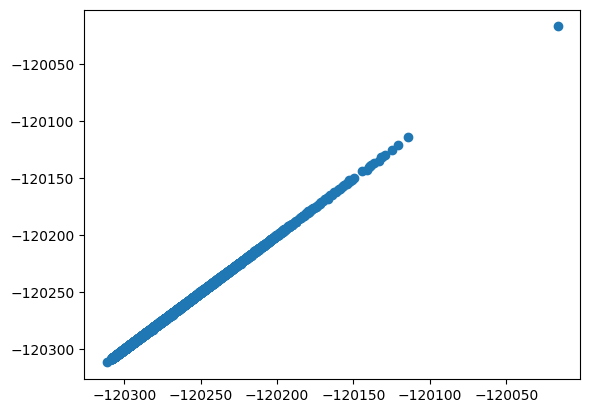

In [17]:
print('r2 score (train) ->', r2_score(en_trans_train, train_energy_mean))
print('MAE (train) ->', mean_absolute_error(en_trans_train, train_energy_mean))
plt.scatter(en_trans_train, train_energy_mean)
plt.show()

r2 score (test) -> 0.9999439650358191
MAE (test) -> 0.07335856457485643


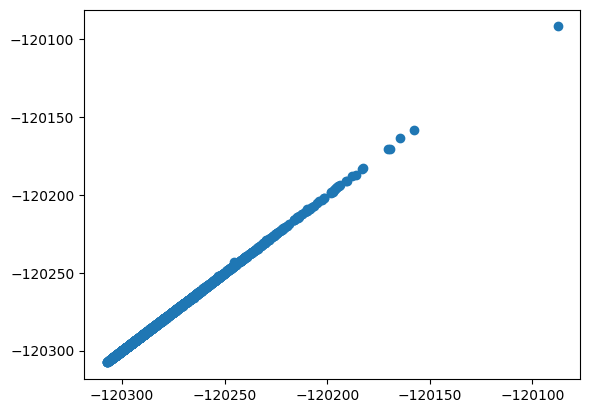

In [18]:
print('r2 score (test) ->', r2_score(en_trans_test, test_energy_mean))
print('MAE (test) ->', mean_absolute_error(en_trans_test, test_energy_mean))
plt.scatter(en_trans_test, test_energy_mean)
plt.show()

r2 score (cis trans) -> 0.44211084538487777
MAE (cis trans) -> 4.413549208439366


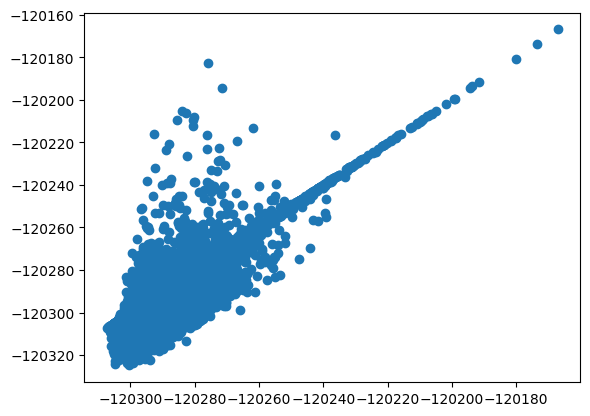

In [19]:
print('r2 score (cis trans) ->', r2_score(energy_cis_trans,ct_energy_mean))
print('MAE (cis trans) ->', mean_absolute_error(energy_cis_trans,ct_energy_mean))
plt.scatter(energy_cis_trans,ct_energy_mean)
plt.show()

r2 score (cis) -> -1.9582060090540647
MAE (cis) -> 12.391631396475491


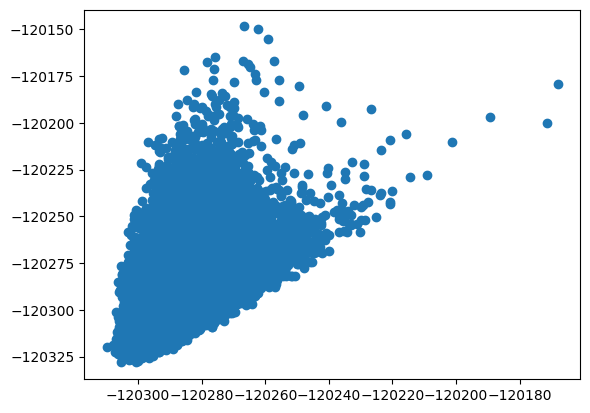

In [20]:
print('r2 score (cis) ->', r2_score(energy_cis,cis_energy_mean))
print('MAE (cis) ->', mean_absolute_error(energy_cis,cis_energy_mean))
plt.scatter(energy_cis,cis_energy_mean)
plt.show()

In [21]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split

data = np.load('ws22_acrolein.npz')
coordinates_trans = np.array(data['R'][70000:])
energy_trans = np.array(data['E'][70000:])
coordinates_trans_train, coordinates_trans_test, en_trans_train, en_trans_test = train_test_split(coordinates_trans, energy_trans, train_size = 0.90, random_state=0)

def r2_descriptor(xyz_matrix: np.ndarray) -> np.ndarray:
    """Build the pairwise atom-atom distance descriptor.

    Args:
    -----
        xyz_matrix: a numpy 3D tensor of shape (n_geometries, n_atoms, 3) containing the stacked
                    Cartesian coordinates of the molecular structures.

    Return:
    -------
        r2_matrix: a numpy 2D array of shape (n_geometries, n_atoms * (n_atoms - 1)/2) with the
                   unique pairwise distances vector calculated for each molecular geometry.
    """
    n_samples, n_atoms, _ = xyz_matrix.shape
    dist_vec_size = int(n_atoms * (n_atoms - 1)/2)
    r2_matrix = np.empty((n_samples, dist_vec_size))
    for idx in range(n_samples):
        distance_matrix = np.zeros((n_atoms, n_atoms))
        geom = xyz_matrix[idx]
        for i, j in combinations(range(len(geom)), 2):
            R = np.linalg.norm(geom[i] - geom[j])
            distance_matrix[j, i] = R
        r2_vector = distance_matrix[np.tril_indices(len(distance_matrix), -1)]
        r2_matrix[idx, :] = r2_vector.reshape(1,-1)
    return r2_matrix


r2_train = r2_descriptor(coordinates_trans_train)
print(r2_train.shape)
r2_test = r2_descriptor(coordinates_trans_test)
r2_cis_trans = r2_descriptor(np.array(data['R'][:20000]))
r2_cis = r2_descriptor(np.array(data['R'][20000:70000]))
print(r2_cis.shape)
full_data = np.append(np.append(np.append(r2_train, r2_test, axis=0), r2_cis_trans, axis=0), r2_cis, axis=0)
#full_data = np.append(r2_train, r2_test, axis=0)
print(full_data.shape)
X = MinMaxScaler().fit_transform(full_data)
print("Performing dimensionality reduction with PCA...\n")
pca_n2 = PCA(n_components=2)
pca_n2.fit(X)
X_transformed = pca_n2.transform(X)
print('Perfomed')

(45000, 28)
(50000, 28)
(120000, 28)
Performing dimensionality reduction with PCA...

Perfomed


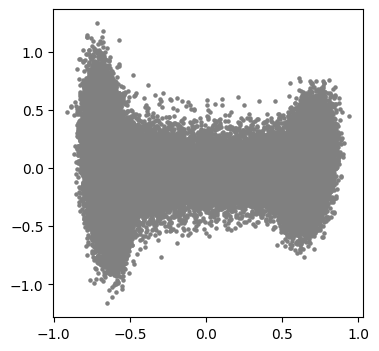

In [22]:
plt.scatter(-X_transformed[:, 0], X_transformed[:, 1], c='gray', s=5)
plt.gcf().set_size_inches(4, 4)

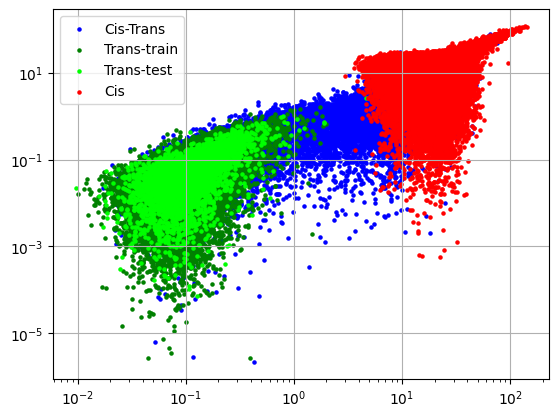

In [23]:
plt.scatter(y=np.abs(energy_cis_trans.flatten() - ct_energy_mean.flatten()), x=ct_energy_std.flatten(), c='b', label='Cis-Trans', s=5)
plt.scatter(y=np.abs(en_trans_train.flatten() - train_energy_mean.flatten()), x=train_energy_std.flatten(), c='g', label='Trans-train', s=5)
plt.scatter(y=np.abs(en_trans_test.flatten() - test_energy_mean.flatten()), x=test_energy_std.flatten(), c='lime', label='Trans-test', s=5)
plt.scatter(y=np.abs(energy_cis.flatten() - cis_energy_mean.flatten()), x=cis_energy_std.flatten(), c='r', label='Cis', s=5)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [24]:
# Plot settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# mpl.rcParams['figure.figsize'] = [7.8,5.9]
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11

# plt.style.use('seaborn-white')
# sns.set(color_codes=True)

legend_settings = {'loc':'upper center', 'ncol':3, 'frameon':True, 'facecolor':'white',
                   'framealpha':0.8, 'bbox_to_anchor':(0.5, 1.11)}

(120000, 1)


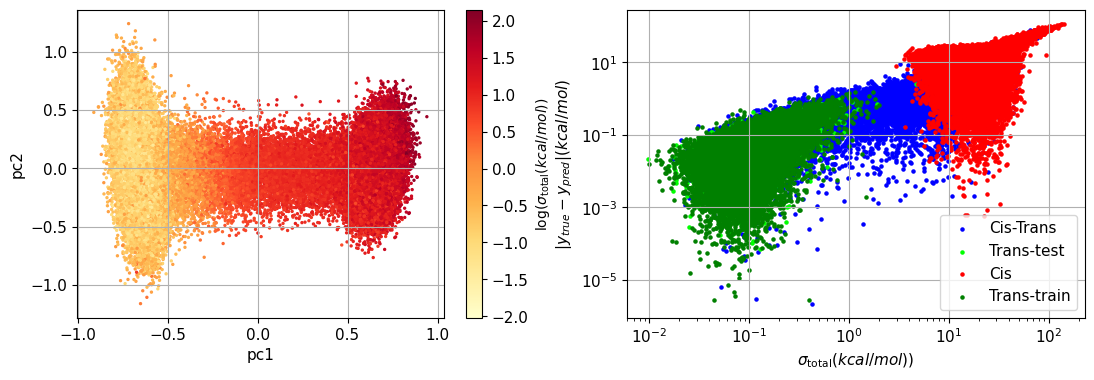

In [25]:
full_std_dev = np.append(np.append(np.append(train_energy_std.reshape(-1, 1), test_energy_std.reshape(-1, 1), axis=0), ct_energy_std.reshape(-1, 1), axis=0), cis_energy_std.reshape(-1, 1), axis=0)
print(full_std_dev.shape)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

im1 = axes[0].scatter(-X_transformed[:, 0], X_transformed[:, 1], c=np.log10(full_std_dev), s=2, cmap='YlOrRd')

axes[0].set_xlabel('pc1')
axes[0].set_ylabel('pc2')
axes[0].grid()
sbar1 = fig.colorbar(im1, ax=axes[0])
sbar1.set_label(r'log($\sigma_{\mathrm{total}}(kcal/mol))$', fontsize=10)
#plt.savefig('PCA_std_dev.png', dpi=600)

axes[1].scatter(y=np.abs(energy_cis_trans.flatten() - ct_energy_mean.flatten()), x=ct_energy_std.flatten(), c='b', label='Cis-Trans', s=5)
axes[1].scatter(y=np.abs(en_trans_test.flatten() - test_energy_mean.flatten()), x=test_energy_std.flatten(), c='lime', label='Trans-test', s=5)
axes[1].scatter(y=np.abs(energy_cis.flatten() - cis_energy_mean.flatten()), x=cis_energy_std.flatten(), c='r', label='Cis', s=5)
axes[1].scatter(y=np.abs(en_trans_train.flatten() - train_energy_mean.flatten()), x=train_energy_std.flatten(), c='g', label='Trans-train', s=5)

axes[1].set_ylabel(r'$|y_{true} - y_{pred}| (kcal/ mol)$')
axes[1].set_xlabel(r'$\sigma_{\mathrm{total}}(kcal/mol))$')
axes[1].grid()
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()
plt.savefig('Acrolein_2000epochs_DE.png', dpi=600, bbox_inches='tight')
plt.show()

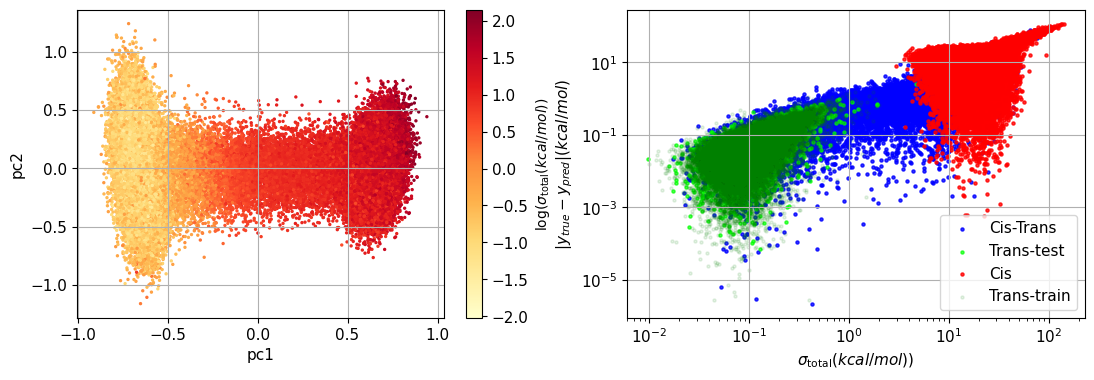

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Subplot 1
im1 = axes[0].scatter(-X_transformed[:, 0], X_transformed[:, 1], c=np.log10(full_std_dev), s=2, cmap='YlOrRd')
axes[0].set_xlabel('pc1')
axes[0].set_ylabel('pc2')
axes[0].grid()
sbar1 = fig.colorbar(im1, ax=axes[0])
sbar1.set_label(r'log($\sigma_{\mathrm{total}}(kcal/mol))$', fontsize=10)

# Subplot 2 with different alpha values
axes[1].scatter(
    y=np.abs(energy_cis_trans.flatten() - ct_energy_mean.flatten()),
    x=ct_energy_std.flatten(), c='b', label='Cis-Trans', s=5, alpha=0.8
)
axes[1].scatter(
    y=np.abs(en_trans_test.flatten() - test_energy_mean.flatten()),
    x=test_energy_std.flatten(), c='lime', label='Trans-test', s=5, alpha=0.7
)
axes[1].scatter(
    y=np.abs(energy_cis.flatten() - cis_energy_mean.flatten()),
    x=cis_energy_std.flatten(), c='r', label='Cis', s=5, alpha=0.8
)
axes[1].scatter(
    y=np.abs(en_trans_train.flatten() - train_energy_mean.flatten()),
    x=train_energy_std.flatten(), c='g', label='Trans-train', s=5, alpha=0.1
)

axes[1].set_ylabel(r'$|y_{true} - y_{pred}| (kcal/ mol)$')
axes[1].set_xlabel(r'$\sigma_{\mathrm{total}}(kcal/mol))$')
axes[1].grid()
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()
plt.savefig('Acrolein_2000epochs_DE.png', dpi=600, bbox_inches='tight')
plt.show()


In [27]:
import uncertainty_toolbox as uct

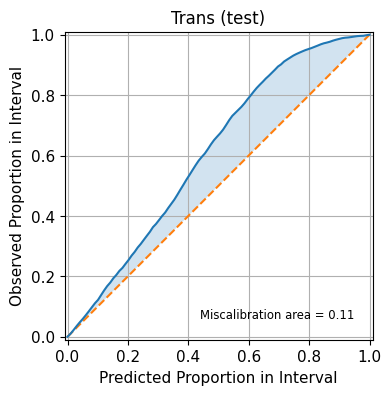

In [28]:
uct.viz.plot_calibration(test_energy_mean, test_energy_std, en_trans_test.ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Trans (test)')
plt.grid()
plt.savefig('Trans_Test-Calibration.png', dpi=600, bbox_inches='tight')
# plt.show()

In [29]:
unct_metrics_bc_gpnormal = uct.metrics.get_all_metrics(test_energy_mean, test_energy_std, en_trans_test.ravel())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.073
  RMSE          0.128
  MDAE          0.049
  MARPD         0.000
  R2            1.000
  Correlation   1.000
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.127
  Mean-absolute Calibration Error       0.108
  Miscalibration Area                   0.109
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.122
     Group Size: 0.56 -- Calibration Error: 0.113
     Group Size: 1.00 -- Calibration Error: 0.108
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.139
     Group Size: 0.56 -- Calibration Error: 0.132
     Group Size: 1.00 -- Calibration Error: 0.127
================

In [30]:
mean = test_energy_mean.reshape(-1, 1)
stddev = test_energy_std.reshape(-1, 1)
ground_truth = en_trans_test.reshape(-1, 1)

# (pred_val_001.reshape(-1, 1), std_val_001.reshape(-1, 1)), targets_val_001.reshape(-1, 1)

nll = NLL()
pinball = PinballLoss()
qce = QCE(marginal=True)
ence = ENCE()

# measure miscalibration with the initialized metrics
# Note: the parameter "reduction" has a major influence to the return shape of the metrics
# see the method docstrings for detailed information
print('NLL: ', nll.measure((mean, stddev), ground_truth, reduction="mean"))
print('Pinball: ', pinball.measure((mean, stddev), ground_truth, q=quantiles, reduction="mean"))
print('QCE: ', qce.measure((mean, stddev), ground_truth, q=quantiles, reduction="mean"))
print('ENCE: ', ence.measure((mean, stddev), ground_truth))

NLL:  -1.098727127698292
Pinball:  0.015757269422237846
QCE:  0.11464210526315789
ENCE:  0.4357231754816682


In [31]:
unct_metrics_bc_gpnormal = uct.metrics.get_all_metrics(ct_energy_mean, ct_energy_std, energy_cis_trans.ravel())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           4.414
  RMSE          7.709
  MDAE          1.246
  MARPD         0.004
  R2            0.442
  Correlation   0.845
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.107
  Mean-absolute Calibration Error       0.096
  Miscalibration Area                   0.097
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.105
     Group Size: 0.56 -- Calibration Error: 0.099
     Group Size: 1.00 -- Calibration Error: 0.096
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.116
     Group Size: 0.56 -- Calibration Error: 0.110
     Group Size: 1.00 -- Calibration Error: 0.107
================

In [32]:
uct.get_all_adversarial_group_calibration(ct_energy_mean, ct_energy_std, energy_cis_trans.ravel(), num_bins=100, verbose=True)

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


{'ma_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
         0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
  'adv_group_cali_mean': array([0.38005556, 0.10327948, 0.10101665, 0.10013829, 0.09888548,
         0.0981971 , 0.09817993, 0.09781403, 0.09703234, 0.095957  ]),
  'adv_group_cali_stderr': array([0.04788711, 0.00305346, 0.00213073, 0.00135143, 0.00130267,
         0.00067049, 0.00068377, 0.00052246, 0.00028353, 0.        ])},
 'rms_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
         0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
  'adv_group_cali_mean': array([0.43319672, 0.11429451, 0.11227658, 0.11135473, 0.11012823,
         0.10899531, 0.10909528, 0.10861542, 0.1078934 , 0.10681024]),
  'adv_group_cali_stderr': array([0.0536686 , 0.00381718, 0.00158715, 0.00166515, 0.00125451,
         0.00091744, 0.00075943, 0.00059907, 0.00054799, 0.    

In [33]:
# ct_energy_mean, ct_energy_std, energy_cis_trans.ravel()

mean = ct_energy_mean.reshape(-1, 1)
stddev = ct_energy_std.reshape(-1, 1)
ground_truth = energy_cis_trans.reshape(-1, 1)

# (pred_val_001.reshape(-1, 1), std_val_001.reshape(-1, 1)), targets_val_001.reshape(-1, 1)

nll = NLL()
pinball = PinballLoss()
qce = QCE(marginal=True)
ence = ENCE()

# measure miscalibration with the initialized metrics
# Note: the parameter "reduction" has a major influence to the return shape of the metrics
# see the method docstrings for detailed information
print('NLL: ', nll.measure((mean, stddev), ground_truth, reduction="mean"))
print('Pinball: ', pinball.measure((mean, stddev), ground_truth, q=quantiles, reduction="mean"))
print('QCE: ', qce.measure((mean, stddev), ground_truth, q=quantiles, reduction="mean"))
print('ENCE: ', ence.measure((mean, stddev), ground_truth))

NLL:  2.1541434214009967
Pinball:  1.0115140742957498
QCE:  0.10223157894736844
ENCE:  0.25615688034599804


In [34]:
print(ct_energy_mean.shape)
print(ct_energy_std.shape)

(20000,)
(20000,)


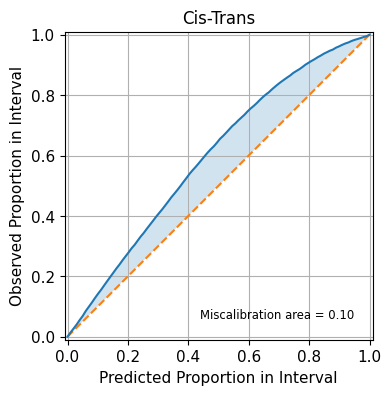

In [35]:
uct.viz.plot_calibration(ct_energy_mean, ct_energy_std, energy_cis_trans.ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Cis-Trans')
plt.grid()
plt.savefig('Cis-Trans_Uncalibrated-Calibration.png', dpi=600, bbox_inches='tight')
#

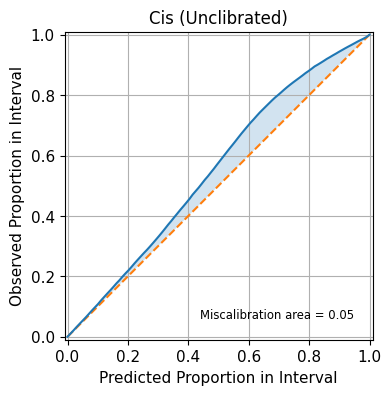

In [36]:
uct.viz.plot_calibration(cis_energy_mean, cis_energy_std, energy_cis.ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Cis (Unclibrated)')
plt.grid()
plt.show()

Calibration

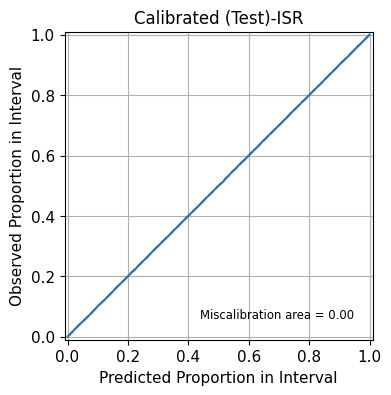

In [37]:
recal_pred_mean = test_energy_mean.flatten()
recal_y = en_trans_test.flatten()
recal_pred_std = test_energy_std.flatten()
exp_props, obs_props = uct.metrics_calibration.get_proportion_lists_vectorized(
    recal_pred_mean, recal_pred_std, recal_y,
)
# Train a recalibration model.
recal_model = uct.recalibration.iso_recal(exp_props, obs_props)

te_recal_exp_props, te_recal_obs_props = uct.metrics_calibration.get_proportion_lists_vectorized(
    test_energy_mean.flatten(), test_energy_std.flatten(), en_trans_test.ravel(), recal_model=recal_model
)

uct.viz.plot_calibration(test_energy_mean.flatten(), test_energy_std.flatten(), en_trans_test.ravel(),
                         exp_props=te_recal_exp_props,
                         obs_props=te_recal_obs_props)
plt.gcf().set_size_inches(4, 4)
plt.title('Calibrated (Test)-ISR')
plt.grid()
plt.savefig('Calibration_Test.png', dpi=600, bbox_inches='tight')

[54120 54121 54122 54123 54124 54125 54126 54127 54128 54129 54130 54131
 54132 54133 54134 54135 54136 54137 54138 54139]


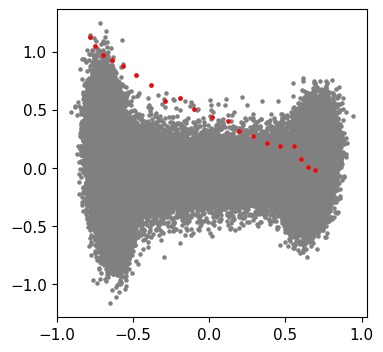

In [38]:
indices = np.arange(54120, 54140)
print(indices)

plt.scatter(-X_transformed[:, 0], X_transformed[:, 1], c='gray', s=5)
plt.scatter(-X_transformed[54120:54140, 0], X_transformed[54120:54140, 1], c='r', s=5)
plt.gcf().set_size_inches(4, 4)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4139 4138 4137 4136 4135 4134 4133 4132 4131 4130 4129 4128 4127 4126
 4125 4124 4123 4122 4121 4120]


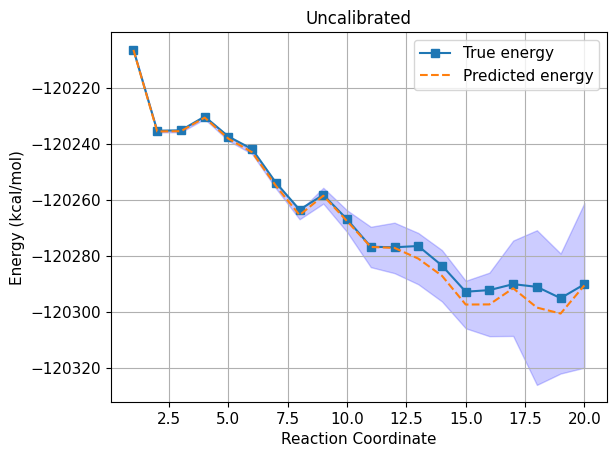

In [39]:
x = np.linspace(1, 20, 20).astype(int)
print(x)
act_indices = indices - 50000
act_indices = act_indices[::-1]
print(act_indices)
plt.plot(x, energy_cis_trans[act_indices], 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices], '--', label='Predicted energy')
plt.fill_between(x, ct_energy_mean[act_indices] -  ct_energy_std[act_indices], ct_energy_mean[act_indices] +  ct_energy_std[act_indices], alpha=0.2, color='b')
plt.ylabel('Energy (kcal/mol)')
plt.xlabel('Reaction Coordinate')
plt.title('Uncalibrated')
plt.grid()
plt.legend()
plt.show()

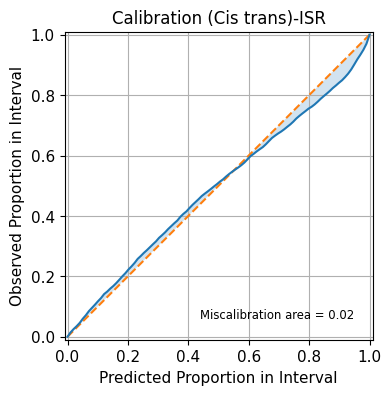

In [40]:
recal_pred_mean = test_energy_mean.flatten()
recal_y = en_trans_test.flatten()
recal_pred_std = test_energy_std.flatten()
exp_props, obs_props = uct.metrics_calibration.get_proportion_lists_vectorized(
    recal_pred_mean, recal_pred_std, recal_y,
)
# Train a recalibration model.
recal_model = uct.recalibration.iso_recal(exp_props, obs_props)

te_recal_exp_props, te_recal_obs_props = uct.metrics_calibration.get_proportion_lists_vectorized(
    ct_energy_mean.flatten(), ct_energy_std.flatten(), energy_cis_trans.ravel(), recal_model=recal_model
)

uct.viz.plot_calibration(ct_energy_mean.flatten(), ct_energy_std.flatten(), energy_cis_trans.ravel(),
                         exp_props=te_recal_exp_props,
                         obs_props=te_recal_obs_props)
plt.gcf().set_size_inches(4, 4)
plt.title('Calibration (Cis trans)-ISR')
plt.grid()
plt.savefig('Calibration_Cis-Trans-ISR.png', dpi=600, bbox_inches='tight')

In [41]:
recal_bounds_energy_67 = uct.metrics_calibration.get_prediction_interval(
    ct_energy_mean.flatten(), ct_energy_std.flatten(), 0.6827, recal_model)

In [42]:
isr_std_67 = (recal_bounds_energy_67.upper - recal_bounds_energy_67.lower) / 2.0

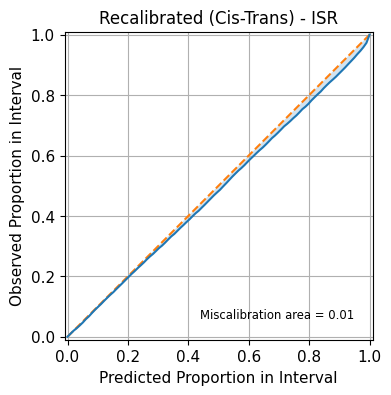

In [43]:
uct.viz.plot_calibration(ct_energy_mean, isr_std_67, energy_cis_trans.ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Recalibrated (Cis-Trans) - ISR')
plt.grid()
# plt.show()
plt.savefig('Cis-Trans_ISR-modified-Calibration.png', dpi=600, bbox_inches='tight')

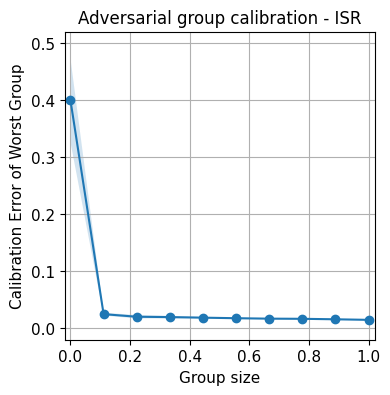

In [44]:
uct.viz.plot_adversarial_group_calibration(ct_energy_mean, isr_std_67, energy_cis_trans.ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Adversarial group calibration - ISR')
plt.grid()
# plt.show()
plt.savefig('AGC-ISR_ws22.png', dpi=600, bbox_inches='tight')

In [45]:
unct_metrics_bc_gpnormal = uct.metrics.get_all_metrics(ct_energy_mean, isr_std_67, energy_cis_trans.ravel())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           4.414
  RMSE          7.709
  MDAE          1.246
  MARPD         0.004
  R2            0.442
  Correlation   0.845
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.017
  Mean-absolute Calibration Error       0.015
  Miscalibration Area                   0.015
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.023
     Group Size: 0.56 -- Calibration Error: 0.018
     Group Size: 1.00 -- Calibration Error: 0.015
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.027
     Group Size: 0.56 -- Calibration Error: 0.020
     Group Size: 1.00 -- Calibration Error: 0.017
================

In [46]:
uct.get_all_adversarial_group_calibration(ct_energy_mean, isr_std_67, energy_cis_trans.ravel(), num_bins=100, verbose=True)

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


{'ma_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
         0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
  'adv_group_cali_mean': array([0.38832323, 0.02385004, 0.02044664, 0.01862124, 0.01809758,
         0.01729456, 0.01749289, 0.01674641, 0.0159335 , 0.0148215 ]),
  'adv_group_cali_stderr': array([0.0600673 , 0.00297898, 0.00204987, 0.00195542, 0.00082499,
         0.00069775, 0.00135741, 0.00047215, 0.00055526, 0.        ])},
 'rms_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
         0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
  'adv_group_cali_mean': array([0.43191732, 0.02586724, 0.02354404, 0.02147793, 0.020755  ,
         0.01960677, 0.01946755, 0.01881533, 0.01846713, 0.017142  ]),
  'adv_group_cali_stderr': array([0.07368084, 0.0030669 , 0.000958  , 0.00190116, 0.00142868,
         0.00075229, 0.00084187, 0.00071318, 0.0005765 , 0.    

In [47]:


# ct_energy_mean, ct_energy_std, energy_cis_trans.ravel()

mean = ct_energy_mean.reshape(-1, 1)
stddev = isr_std_67.reshape(-1, 1)
ground_truth = energy_cis_trans.reshape(-1, 1)

# (pred_val_001.reshape(-1, 1), std_val_001.reshape(-1, 1)), targets_val_001.reshape(-1, 1)

nll = NLL()
pinball = PinballLoss()
qce = QCE(marginal=True)
ence = ENCE()

# measure miscalibration with the initialized metrics
# Note: the parameter "reduction" has a major influence to the return shape of the metrics
# see the method docstrings for detailed information
print('NLL: ', nll.measure((mean, stddev), ground_truth, reduction="mean"))
print('Pinball: ', pinball.measure((mean, stddev), ground_truth, q=quantiles, reduction="mean"))
print('QCE: ', qce.measure((mean, stddev), ground_truth, q=quantiles, reduction="mean"))
print('ENCE: ', ence.measure((mean, stddev), ground_truth))

NLL:  2.1137828543778867
Pinball:  0.925665844817535
QCE:  0.01554210526315788
ENCE:  0.19924566542919092


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4139 4138 4137 4136 4135 4134 4133 4132 4131 4130 4129 4128 4127 4126
 4125 4124 4123 4122 4121 4120]


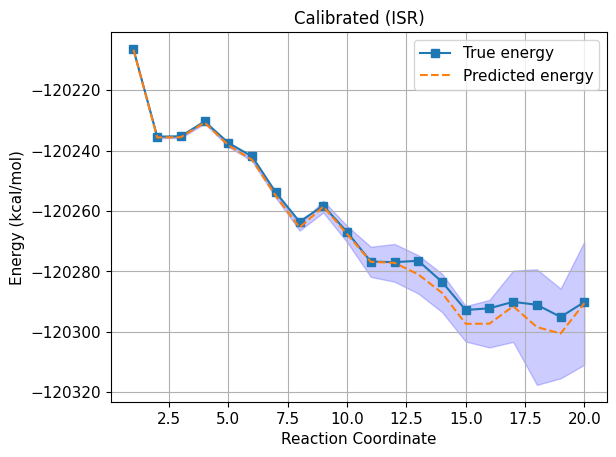

In [48]:
x = np.linspace(1, 20, 20).astype(int)
print(x)
act_indices = indices - 50000
act_indices = act_indices[::-1]
print(act_indices)
plt.plot(x, energy_cis_trans[act_indices], 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices], '--', label='Predicted energy')
plt.fill_between(x, recal_bounds_energy_67.lower[act_indices], recal_bounds_energy_67.upper[act_indices], alpha=0.2, color='b')
plt.ylabel('Energy (kcal/mol)')
plt.xlabel('Reaction Coordinate')
plt.title('Calibrated (ISR)')
plt.grid()
plt.legend()
plt.show()

##Standard Scaling

std scaling -> 0.7053147775330019


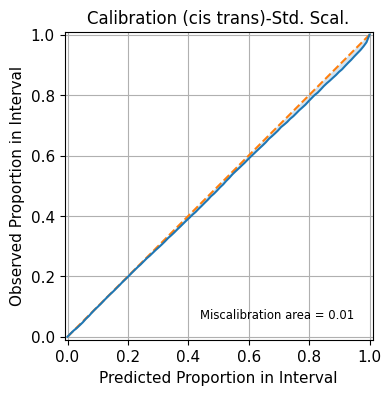

In [49]:
recal_pred_mean = test_energy_mean.flatten()
recal_y = en_trans_test.flatten()
recal_pred_std = test_energy_std.flatten()

std_scaling_energy = uct.recalibration.optimize_recalibration_ratio(
      recal_pred_mean, recal_pred_std, recal_y, criterion="miscal"
)
new_pred_stds_energy = std_scaling_energy * ct_energy_std.flatten()
print('std scaling ->', std_scaling_energy)
 # Show the updated average calibration plot
uct.viz.plot_calibration(ct_energy_mean.flatten(), new_pred_stds_energy, energy_cis_trans.ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Calibration (cis trans)-Std. Scal.')
plt.grid()
plt.savefig('Calibration_Cis-Trans-Std-Scaling.png', dpi=600, bbox_inches='tight')

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4139 4138 4137 4136 4135 4134 4133 4132 4131 4130 4129 4128 4127 4126
 4125 4124 4123 4122 4121 4120]


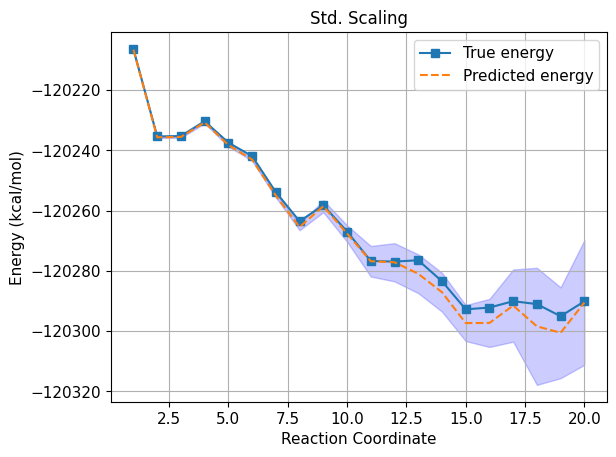

In [50]:
x = np.linspace(1, 20, 20).astype(int)
print(x)
act_indices = indices - 50000
act_indices = act_indices[::-1]
print(act_indices)
plt.plot(x, energy_cis_trans[act_indices], 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices], '--', label='Predicted energy')
plt.fill_between(x, ct_energy_mean[act_indices] -  std_scaling_energy * ct_energy_std[act_indices], ct_energy_mean[act_indices] +  std_scaling_energy * ct_energy_std[act_indices], alpha=0.2, color='b')
plt.ylabel('Energy (kcal/mol)')
plt.xlabel('Reaction Coordinate')
plt.title('Std. Scaling')
plt.grid()
plt.legend()
plt.show()

In [51]:
unct_metrics_bc_gpnormal = uct.metrics.get_all_metrics(ct_energy_mean.flatten(), new_pred_stds_energy, energy_cis_trans.ravel())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           4.414
  RMSE          7.709
  MDAE          1.246
  MARPD         0.004
  R2            0.442
  Correlation   0.845
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.012
  Mean-absolute Calibration Error       0.010
  Miscalibration Area                   0.010
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.019
     Group Size: 0.56 -- Calibration Error: 0.013
     Group Size: 1.00 -- Calibration Error: 0.010
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.023
     Group Size: 0.56 -- Calibration Error: 0.015
     Group Size: 1.00 -- Calibration Error: 0.012
================

In [52]:


# ct_energy_mean, ct_energy_std, energy_cis_trans.ravel()

mean = ct_energy_mean.reshape(-1, 1)
stddev = new_pred_stds_energy.reshape(-1, 1)
ground_truth = energy_cis_trans.reshape(-1, 1)

# (pred_val_001.reshape(-1, 1), std_val_001.reshape(-1, 1)), targets_val_001.reshape(-1, 1)

nll = NLL()
pinball = PinballLoss()
qce = QCE(marginal=True)
ence = ENCE()

# measure miscalibration with the initialized metrics
# Note: the parameter "reduction" has a major influence to the return shape of the metrics
# see the method docstrings for detailed information
print('NLL: ', nll.measure((mean, stddev), ground_truth, reduction="mean"))
print('Pinball: ', pinball.measure((mean, stddev), ground_truth, q=quantiles, reduction="mean"))
print('QCE: ', qce.measure((mean, stddev), ground_truth, q=quantiles, reduction="mean"))
print('ENCE: ', ence.measure((mean, stddev), ground_truth))

NLL:  2.1101956464383846
Pinball:  0.9244052620474258
QCE:  0.010449999999999982
ENCE:  0.19010477159529718


GPNormal

In [53]:
manual_seed(0)
np.random.seed(0)

In [54]:
use_cuda = False  # or: "cuda:0", "cuda:1", etc.
# initialize tensorboard logging
tensorboard = SummaryWriter("logs/netcal/regression/artificial")
# reliability = ReliabilityRegression(quantiles=bins+1)
# figures = []

In [55]:
gpnormal = GPNormal(n_inducing_points=50, n_random_samples=256, n_epochs=50, use_cuda=use_cuda)
gpnormal.fit((test_energy_mean.reshape(-1, 1), test_energy_std.reshape(-1, 1)), en_trans_test.reshape(-1, 1), tensorboard=tensorboard)
ystd_gpnormal = gpnormal.transform((ct_energy_mean.reshape(-1, 1), ct_energy_std.reshape(-1, 1)))

# squeeze calibrated stddev
# ymean_gpnormal = test_energy_mean.reshape(-1, 1)
# ystd_gpnormal = ystd_gpnormal[..., 0]

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2190.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
Loss: -1.2147: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


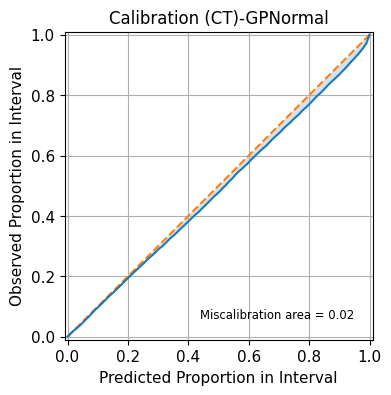

In [56]:
uct.viz.plot_calibration(ct_energy_mean.ravel(), ystd_gpnormal.ravel(), energy_cis_trans.ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Calibration (CT)-GPNormal')
plt.grid()
plt.savefig('Calibration_Cis-Trans-GPNormal.png', dpi=600, bbox_inches='tight')

In [57]:
unct_metrics_bc_gpnormal = uct.metrics.get_all_metrics(ct_energy_mean.ravel(), ystd_gpnormal.ravel(), energy_cis_trans.ravel())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           4.414
  RMSE          7.709
  MDAE          1.246
  MARPD         0.004
  R2            0.442
  Correlation   0.845
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.020
  Mean-absolute Calibration Error       0.018
  Miscalibration Area                   0.018
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.026
     Group Size: 0.56 -- Calibration Error: 0.021
     Group Size: 1.00 -- Calibration Error: 0.018
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.031
     Group Size: 0.56 -- Calibration Error: 0.024
     Group Size: 1.00 -- Calibration Error: 0.020
================

In [58]:
uct.get_all_adversarial_group_calibration(ct_energy_mean.ravel(), isr_std_67.ravel(), energy_cis_trans.ravel(), num_bins=100, verbose=True)
#

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


{'ma_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
         0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
  'adv_group_cali_mean': array([0.37175253, 0.02387879, 0.02116657, 0.019475  , 0.0179827 ,
         0.01801245, 0.01745585, 0.01665038, 0.01596238, 0.0148215 ]),
  'adv_group_cali_stderr': array([0.06106539, 0.00181618, 0.00207238, 0.00108558, 0.00110993,
         0.00121939, 0.00086445, 0.00083022, 0.00043373, 0.        ])},
 'rms_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
         0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
  'adv_group_cali_mean': array([0.46375165, 0.02878939, 0.02271537, 0.02197007, 0.02130149,
         0.02008184, 0.01949119, 0.01890102, 0.0183302 , 0.017142  ]),
  'adv_group_cali_stderr': array([0.05424446, 0.00455926, 0.00276168, 0.00202424, 0.00125134,
         0.00062903, 0.00088518, 0.00064128, 0.00035633, 0.    

In [59]:
uct.get_all_average_calibration(ct_energy_mean.ravel(), ct_energy_std.ravel(), energy_cis_trans.ravel(), num_bins=100, verbose=True)

 (2/n) Calculating average calibration metrics


{'rms_cal': 0.10681023823862852,
 'ma_cal': 0.09595699999999996,
 'miscal_area': 0.09692626262626261}

In [60]:
# Plot settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# mpl.rcParams['figure.figsize'] = [7.8,5.9]
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11

# plt.style.use('seaborn-white')
# sns.set(color_codes=True)

legend_settings = {'loc':'upper center', 'ncol':3, 'frameon':True, 'facecolor':'white',
                   'framealpha':0.8, 'bbox_to_anchor':(0.5, 1.11)}

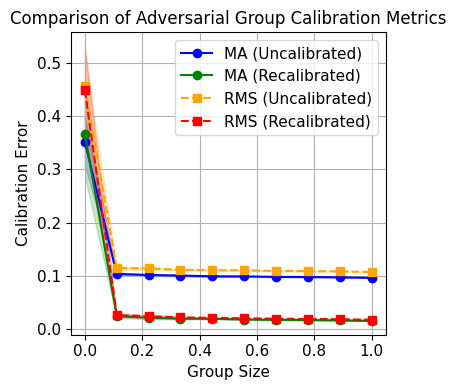

In [61]:


# Data for Uncalibrated
group_sizes_uncal = np.array([0.0, 0.11111111, 0.22222222, 0.33333333, 0.44444444,
                              0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.0])
ma_mean_uncal = np.array([0.3525202, 0.10323087, 0.10128803, 0.10029249, 0.09879222,
                          0.09863775, 0.09778309, 0.09755972, 0.09692361, 0.095957])
ma_stderr_uncal = np.array([0.04605367, 0.00275251, 0.00181752, 0.00173523, 0.00128661,
                            0.00082444, 0.00052969, 0.00082141, 0.00022636, 0.0])
rms_mean_uncal = np.array([0.45652292, 0.11412711, 0.11367041, 0.1111955, 0.11023052,
                           0.11025667, 0.10895945, 0.10853382, 0.10821438, 0.10681024])
rms_stderr_uncal = np.array([0.06310008, 0.00343273, 0.00218325, 0.00115129, 0.00076252,
                             0.00120737, 0.00058379, 0.00059831, 0.00052724, 0.0])

# Data for Recalibrated
group_sizes_recal = group_sizes_uncal  # Same group sizes
ma_mean_recal = np.array([0.36622727, 0.02391649, 0.0207687, 0.01927412, 0.01887533,
                          0.01748177, 0.01687838, 0.01644712, 0.01584517, 0.0148215])
ma_stderr_recal = np.array([0.07925439, 0.00360893, 0.0023116, 0.00181519, 0.00084257,
                            0.00079496, 0.00097896, 0.00056459, 0.00032383, 0.0])
rms_mean_recal = np.array([0.44930654, 0.02563023, 0.02384587, 0.02142789, 0.0207023,
                           0.01983068, 0.01911242, 0.01869014, 0.01819992, 0.017142])
rms_stderr_recal = np.array([0.08288811, 0.0030305, 0.002261, 0.0018788, 0.0011688,
                             0.00085013, 0.00068065, 0.00070762, 0.00023119, 0.0])

# Create the plot
plt.gcf().set_size_inches(4, 4)

# MAE: Uncalibrated and Recalibrated
plt.plot(group_sizes_uncal, ma_mean_uncal, label='MA (Uncalibrated)', color='blue', linestyle='-', marker='o')
plt.fill_between(group_sizes_uncal, ma_mean_uncal - ma_stderr_uncal, ma_mean_uncal + ma_stderr_uncal, color='blue', alpha=0.2)
plt.plot(group_sizes_recal, ma_mean_recal, label='MA (Recalibrated)', color='green', linestyle='-', marker='o')
plt.fill_between(group_sizes_recal, ma_mean_recal - ma_stderr_recal, ma_mean_recal + ma_stderr_recal, color='green', alpha=0.2)

# RMSE: Uncalibrated and Recalibrated
plt.plot(group_sizes_uncal, rms_mean_uncal, label='RMS (Uncalibrated)', color='orange', linestyle='--', marker='s')
plt.fill_between(group_sizes_uncal, rms_mean_uncal - rms_stderr_uncal, rms_mean_uncal + rms_stderr_uncal, color='orange', alpha=0.2)
plt.plot(group_sizes_recal, rms_mean_recal, label='RMS (Recalibrated)', color='red', linestyle='--', marker='s')
plt.fill_between(group_sizes_recal, rms_mean_recal - rms_stderr_recal, rms_mean_recal + rms_stderr_recal, color='red', alpha=0.2)

# Add titles and labels
plt.xlabel('Group Size')
plt.ylabel('Calibration Error')
plt.title('Comparison of Adversarial Group Calibration Metrics')
plt.legend(loc='upper right')
plt.grid()

# Show the plot
plt.tight_layout()
plt.savefig('AGC_Uncal_recal_comparison_energy.png', dpi=600, bbox_inches='tight')


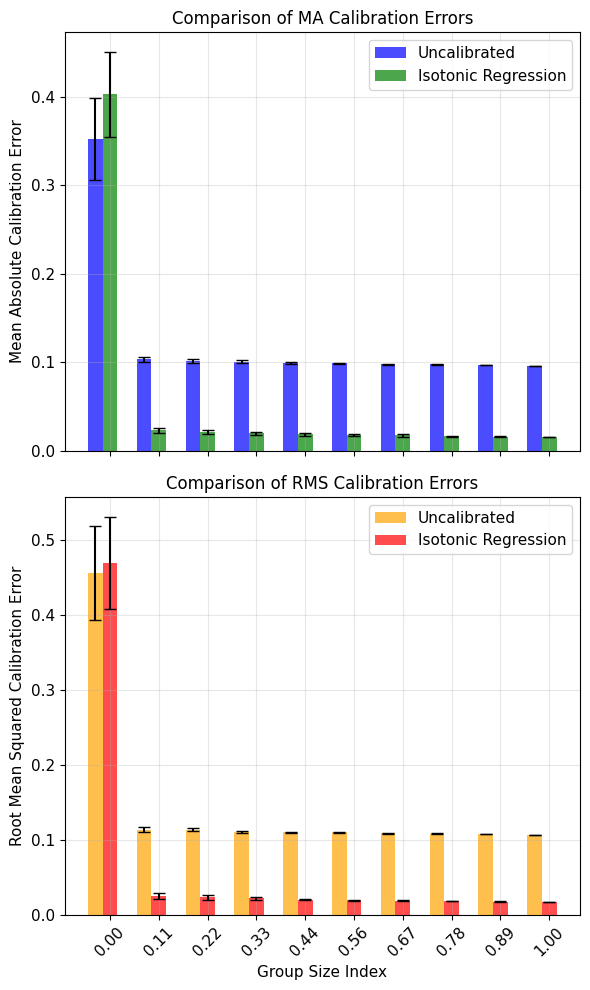

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Group size
group_sizes = np.array([0.0, 0.11111111, 0.22222222, 0.33333333, 0.44444444,
                        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.0])

# Uncalibrated data (same as before)
ma_mean_uncal = np.array([0.3525202, 0.10323087, 0.10128803, 0.10029249, 0.09879222,
                          0.09863775, 0.09778309, 0.09755972, 0.09692361, 0.095957])
ma_stderr_uncal = np.array([0.04605367, 0.00275251, 0.00181752, 0.00173523, 0.00128661,
                            0.00082444, 0.00052969, 0.00082141, 0.00022636, 0.0])
rms_mean_uncal = np.array([0.45652292, 0.11412711, 0.11367041, 0.1111955, 0.11023052,
                           0.11025667, 0.10895945, 0.10853382, 0.10821438, 0.10681024])
rms_stderr_uncal = np.array([0.06310008, 0.00343273, 0.00218325, 0.00115129, 0.00076252,
                             0.00120737, 0.00058379, 0.00059831, 0.00052724, 0.0])

# New isotonic regression data
ma_mean_isotonic = np.array([0.40276768, 0.02289259, 0.02057028, 0.01939464, 0.01829071,
                             0.01732443, 0.01731242, 0.01626353, 0.01586791, 0.0148215])
ma_stderr_isotonic = np.array([0.04779712, 0.00313127, 0.00219202, 0.00200683, 0.00157213,
                               0.00086331, 0.00147772, 0.00059112, 0.00024306, 0.0])
rms_mean_isotonic = np.array([0.46979938, 0.02553751, 0.02356043, 0.02265152, 0.02071926,
                              0.01989364, 0.01929711, 0.01873094, 0.0180986, 0.017142])
rms_stderr_isotonic = np.array([0.06149856, 0.00345733, 0.00303348, 0.00188307, 0.00065744,
                                0.00079016, 0.00087813, 0.00056677, 0.00036081, 0.0])

# Bar positions and width
x = np.arange(len(group_sizes))
width = 0.3

# Plot
fig, ax = plt.subplots(2, 1, figsize=(6, 10), sharex=True)

# Plot for MA
ax[0].bar(x - width, ma_mean_uncal, width, yerr=ma_stderr_uncal, label='Uncalibrated', color='blue', alpha=0.7, capsize=4)
ax[0].bar(x, ma_mean_isotonic, width, yerr=ma_stderr_isotonic, label='Isotonic Regression', color='green', alpha=0.7, capsize=4)

ax[0].set_ylabel('Mean Absolute Calibration Error')
ax[0].set_title('Comparison of MA Calibration Errors')
ax[0].legend()
ax[0].grid(alpha=0.3)

# Plot for RMS
ax[1].bar(x - width, rms_mean_uncal, width, yerr=rms_stderr_uncal, label='Uncalibrated', color='orange', alpha=0.7, capsize=4)
ax[1].bar(x, rms_mean_isotonic, width, yerr=rms_stderr_isotonic, label='Isotonic Regression', color='red', alpha=0.7, capsize=4)

ax[1].set_xlabel('Group Size Index')
ax[1].set_ylabel('Root Mean Squared Calibration Error')
ax[1].set_title('Comparison of RMS Calibration Errors')
ax[1].legend()
ax[1].grid(alpha=0.3)

# Group size tick labels
plt.xticks(x, [f"{g:.2f}" for g in group_sizes], rotation=45)

plt.tight_layout()
plt.savefig('AGC_Uncal_recal_comparison_energy.png', dpi=600, bbox_inches='tight')


In [63]:


# ct_energy_mean, ct_energy_std, energy_cis_trans.ravel()

mean = ct_energy_mean.reshape(-1, 1)
stddev = ystd_gpnormal.reshape(-1, 1)
ground_truth = energy_cis_trans.reshape(-1, 1)

# (pred_val_001.reshape(-1, 1), std_val_001.reshape(-1, 1)), targets_val_001.reshape(-1, 1)

nll = NLL()
pinball = PinballLoss()
qce = QCE(marginal=True)
ence = ENCE()

# measure miscalibration with the initialized metrics
# Note: the parameter "reduction" has a major influence to the return shape of the metrics
# see the method docstrings for detailed information
print('NLL: ', nll.measure((mean, stddev), ground_truth, reduction="mean"))
print('Pinball: ', pinball.measure((mean, stddev), ground_truth, q=quantiles, reduction="mean"))
print('QCE: ', qce.measure((mean, stddev), ground_truth, q=quantiles, reduction="mean"))
print('ENCE: ', ence.measure((mean, stddev), ground_truth))

NLL:  2.1166679842997502
Pinball:  0.9271622275549665
QCE:  0.01882894736842104
ENCE:  0.2051068328386422


In [64]:
# Plot settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# mpl.rcParams['figure.figsize'] = [7.8,5.9]
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['legend.fontsize'] = 15

# plt.style.use('seaborn-white')
# sns.set(color_codes=True)

legend_settings = {'loc':'upper center', 'ncol':3, 'frameon':True, 'facecolor':'white',
                   'framealpha':0.8, 'bbox_to_anchor':(0.5, 1.11)}

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4139 4138 4137 4136 4135 4134 4133 4132 4131 4130 4129 4128 4127 4126
 4125 4124 4123 4122 4121 4120]


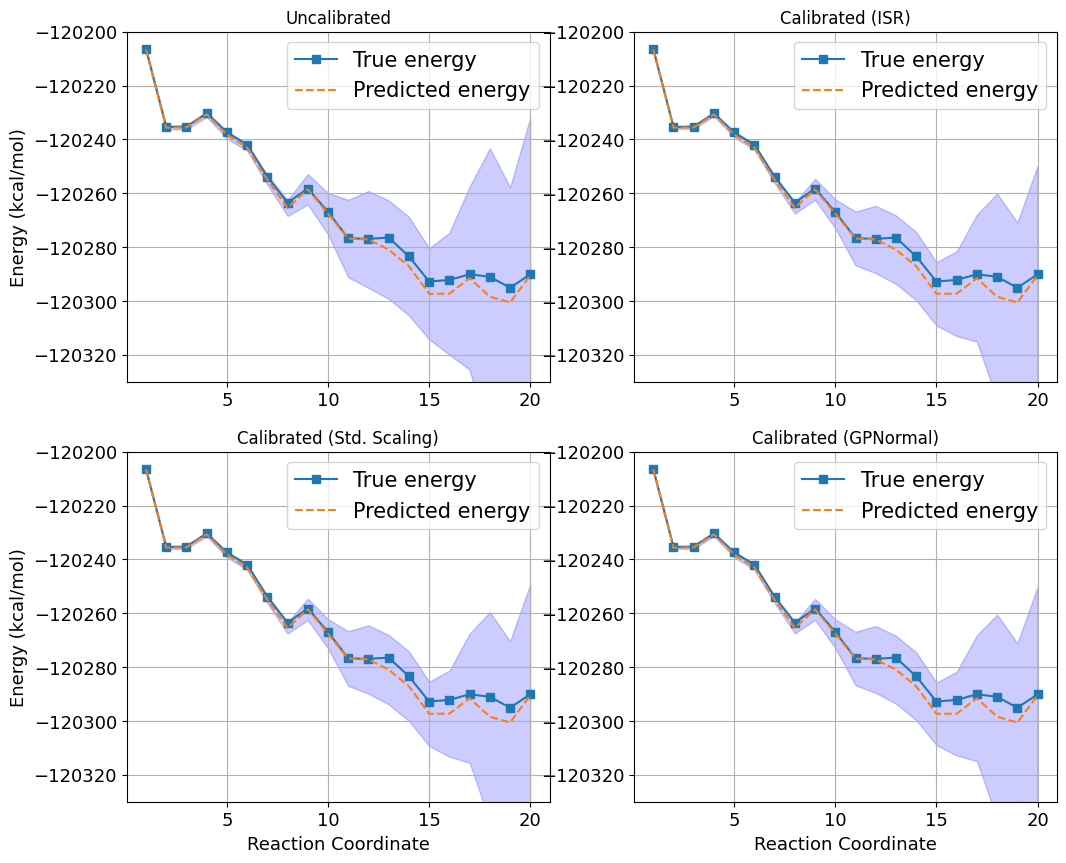

In [65]:
std_scale_N = 2
tolerance = 0.0

x = np.linspace(1, 20, 20).astype(int)
print(x)
act_indices = indices - 50000
act_indices = act_indices[::-1]
print(act_indices)
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(x, energy_cis_trans[act_indices], 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices], '--', label='Predicted energy')
# plt.fill_between(x, ct_energy_mean[act_indices] - ct_energy_std[act_indices], ct_energy_mean[act_indices] + ct_energy_std[act_indices], alpha=0.2, color='b')
plt.fill_between(x, ct_energy_mean[act_indices] - std_scale_N * ct_energy_std[act_indices], ct_energy_mean[act_indices] + std_scale_N * ct_energy_std[act_indices], alpha=0.2, color='b')
plt.ylim(-120330, -120200)
plt.ylabel('Energy (kcal/mol)')
# plt.xlabel('Reaction Coordinate')
plt.title('Uncalibrated')
plt.grid()
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(x, energy_cis_trans[act_indices], 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices], '--', label='Predicted energy')
plt.fill_between(x, ct_energy_mean[act_indices] - std_scale_N * isr_std_67[act_indices] - tolerance, ct_energy_mean[act_indices] + std_scale_N * isr_std_67[act_indices] + tolerance, alpha=0.2, color='b')
# plt.fill_between(x, recal_bounds_energy_95.lower[act_indices], recal_bounds_energy_95.upper[act_indices], alpha=0.2, color='b')
plt.ylim(-120330, -120200)
# plt.ylabel('Energy (kcal/mol)')
# plt.xlabel('Reaction Coordinate')
plt.title('Calibrated (ISR)')
plt.grid()
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(x, energy_cis_trans[act_indices], 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices], '--', label='Predicted energy')
plt.fill_between(x, ct_energy_mean[act_indices] - std_scale_N * new_pred_stds_energy[act_indices] - tolerance, ct_energy_mean[act_indices] + std_scale_N * new_pred_stds_energy[act_indices] + tolerance, alpha=0.2, color='b')
#plt.fill_between(x, ct_energy_mean[act_indices] - 1.96 * std_scaling * ct_energy_std[act_indices], ct_energy_mean[act_indices] + 1.96 * std_scaling * ct_energy_std[act_indices], alpha=0.2, color='b')
plt.ylim(-120330, -120200)
plt.ylabel('Energy (kcal/mol)')
plt.xlabel('Reaction Coordinate')
plt.title('Calibrated (Std. Scaling)')
plt.grid()
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(x, energy_cis_trans[act_indices], 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices], '--', label='Predicted energy')
plt.fill_between(x, ct_energy_mean[act_indices] - std_scale_N * ystd_gpnormal[act_indices].flatten() - tolerance, ct_energy_mean[act_indices] + std_scale_N * ystd_gpnormal[act_indices].flatten() + tolerance, alpha=0.2, color='b')
#plt.fill_between(x, ct_energy_mean[act_indices] - 1.96 * ystd_gpnormal[act_indices].flatten(), ct_energy_mean[act_indices] + 1.96 * ystd_gpnormal[act_indices].flatten(), alpha=0.2, color='b')
# plt.ylabel('Energy (kcal/mol)')
plt.ylim(-120330, -120200)
plt.xlabel('Reaction Coordinate')
plt.title('Calibrated (GPNormal)')
plt.grid()
plt.legend()
plt.savefig('Calibration_Comparison_Energy_modified.png', dpi=600, bbox_inches='tight')
# plt.show()

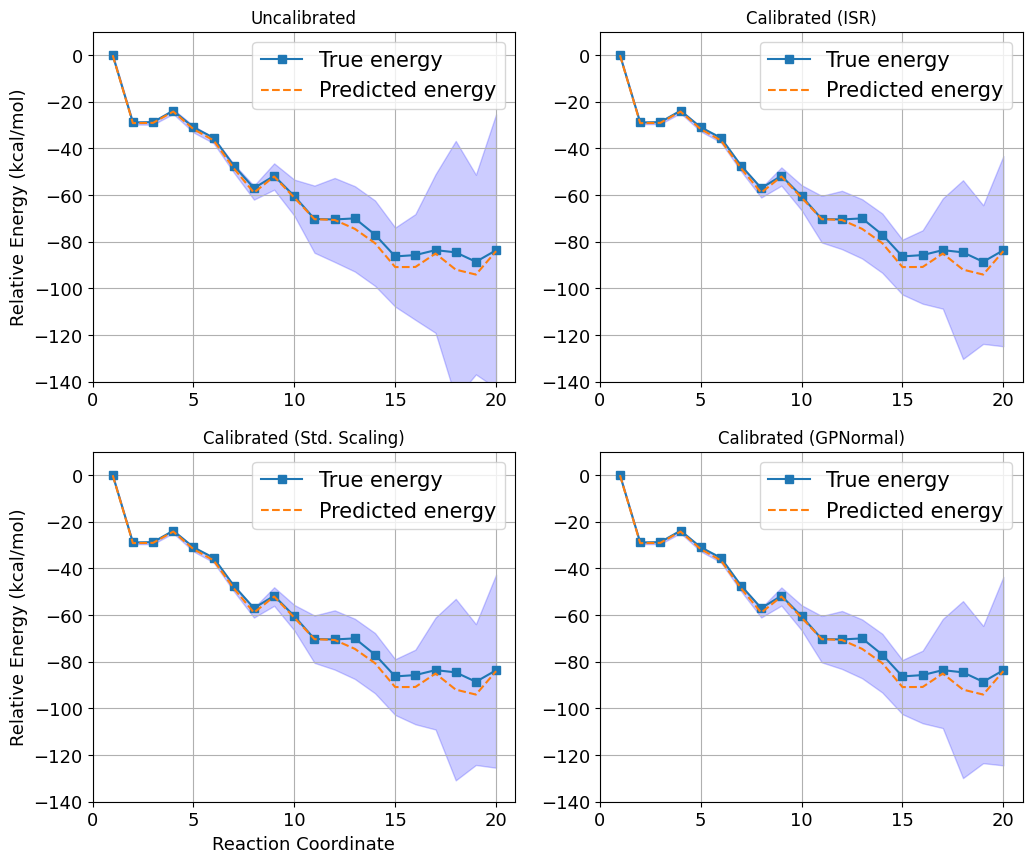

In [66]:
import matplotlib.pyplot as plt
import numpy as np

std_scale_N = 2
tolerance = 0.0

x = np.linspace(1, 20, 20).astype(int)
act_indices = indices - 50000
act_indices = act_indices[::-1]

# Find the maximum energy value to normalize
y_max = energy_cis_trans[act_indices].max()

plt.figure(figsize=(12, 10))

# Subplot 1: Uncalibrated
plt.subplot(2, 2, 1)
plt.plot(x, energy_cis_trans[act_indices] - y_max, 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices] - y_max, '--', label='Predicted energy')
plt.fill_between(
    x,
    (ct_energy_mean[act_indices] - std_scale_N * ct_energy_std[act_indices]) - y_max,
    (ct_energy_mean[act_indices] + std_scale_N * ct_energy_std[act_indices]) - y_max,
    alpha=0.2, color='b'
)

plt.ylim(-140, 10)
plt.ylabel('Relative Energy (kcal/mol)')
plt.title('Uncalibrated')
plt.grid()
plt.legend()
plt.xticks(np.arange(0, 21, 5))  # Set x-axis major ticks at every 5 units

# Subplot 2: Calibrated (ISR)
plt.subplot(2, 2, 2)
plt.plot(x, energy_cis_trans[act_indices] - y_max, 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices] - y_max, '--', label='Predicted energy')
plt.fill_between(
    x,
    (ct_energy_mean[act_indices] - std_scale_N * isr_std_67[act_indices] - tolerance) - y_max,
    (ct_energy_mean[act_indices] + std_scale_N * isr_std_67[act_indices] + tolerance) - y_max,
    alpha=0.2, color='b'
)

plt.ylim(-140, 10)
plt.title('Calibrated (ISR)')
plt.grid()
plt.legend()
plt.xticks(np.arange(0, 21, 5))  # Set x-axis major ticks at every 5 units

# Subplot 3: Calibrated (Std. Scaling)
plt.subplot(2, 2, 3)
plt.plot(x, energy_cis_trans[act_indices] - y_max, 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices] - y_max, '--', label='Predicted energy')
plt.fill_between(
    x,
    (ct_energy_mean[act_indices] - std_scale_N * new_pred_stds_energy[act_indices] - tolerance) - y_max,
    (ct_energy_mean[act_indices] + std_scale_N * new_pred_stds_energy[act_indices] + tolerance) - y_max,
    alpha=0.2, color='b'
)

plt.ylim(-140, 10)
plt.ylabel('Relative Energy (kcal/mol)')
plt.xlabel('Reaction Coordinate')
plt.title('Calibrated (Std. Scaling)')
plt.grid()
plt.legend()
plt.xticks(np.arange(0, 21, 5))  # Set x-axis major ticks at every 5 units

# Subplot 4: Calibrated (GPNormal)
plt.subplot(2, 2, 4)
plt.plot(x, energy_cis_trans[act_indices] - y_max, 's-', label='True energy')
plt.plot(x, ct_energy_mean[act_indices] - y_max, '--', label='Predicted energy')
plt.fill_between(
    x,
    (ct_energy_mean[act_indices] - std_scale_N * ystd_gpnormal[act_indices].flatten() - tolerance) - y_max,
    (ct_energy_mean[act_indices] + std_scale_N * ystd_gpnormal[act_indices].flatten() + tolerance) - y_max,
    alpha=0.2, color='b'
)

plt.ylim(-140, 10)
plt.title('Calibrated (GPNormal)')
plt.grid()
plt.legend()
plt.xticks(np.arange(0, 21, 5))  # Set x-axis major ticks at every 5 units

# Save the figure
plt.savefig('Calibration_Comparison_Energy_ticks.png', dpi=600, bbox_inches='tight')

In [67]:
threshold = 1
tolerance = 0.00

# Uncalibrated

indices_1_energy = np.where(2 * ct_energy_std < threshold)[0]
print('Samples in low uncertainty region:', indices_1_energy.shape)
false_indices_energy = np.where(np.abs(ct_energy_mean[indices_1_energy] - energy_cis_trans.ravel()[indices_1_energy]) > threshold)
print('Points with absolue error > 1kcal/mol:', false_indices_energy[0].shape)

# ISR

isr_std_67 = (recal_bounds_energy_67.upper - recal_bounds_energy_67.lower) / 2.0
isr_std_67 = isr_std_67
indices_1_isr_energy = np.where(2 * isr_std_67 + tolerance < threshold)[0]
pca_indices_1_isr_energy = 50000 + indices_1_isr_energy
print('Samples in low uncertainty region:', np.shape(indices_1_isr_energy))
false_indices_isr_energy = np.where(np.abs(ct_energy_mean[indices_1_isr_energy] - energy_cis_trans.ravel()[indices_1_isr_energy]) > threshold)
print('Points with absolue error > 1kcal/mol:', false_indices_isr_energy[0].shape)

# Standard Scaling

mod_new_pred_stds_energy = new_pred_stds_energy

indices_1_ss_energy = np.where(2 * mod_new_pred_stds_energy + tolerance < threshold)[0]
pca_indices_1_ss_energy = 50000 + indices_1_ss_energy
print('Samples in low uncertainty region:', np.shape(indices_1_ss_energy))

false_indices_ss_energy = np.where(np.abs(ct_energy_mean[indices_1_ss_energy] - energy_cis_trans.ravel()[indices_1_ss_energy]) > threshold)
print('Points with absolue error > 1kcal/mol:', false_indices_ss_energy[0].shape)

# GPNormal

mod_ystd_gpnormal = ystd_gpnormal

indices_1_gp_energy = np.where(2 * mod_ystd_gpnormal + tolerance < threshold)[0]
pca_indices_1_gp_energy = 50000 + indices_1_gp_energy
print('Samples in low uncertainty region:', np.shape(indices_1_gp_energy))

false_indices_gp_energy = np.where(np.abs(ct_energy_mean[indices_1_gp_energy] - energy_cis_trans.ravel()[indices_1_gp_energy]) > threshold)
print('Points with absolue error > 1kcal/mol:', false_indices_gp_energy[0].shape)

Samples in low uncertainty region: (5226,)
Points with absolue error > 1kcal/mol: (11,)
Samples in low uncertainty region: (5904,)
Points with absolue error > 1kcal/mol: (46,)
Samples in low uncertainty region: (5875,)
Points with absolue error > 1kcal/mol: (44,)
Samples in low uncertainty region: (5921,)
Points with absolue error > 1kcal/mol: (46,)


#Force

In [68]:
def take_norm(data):
    # Extract all three components (x, y, z) of the force vectors
    last_three_components = data[..., -3:]

    # Calculate the norm (magnitude) of the 3D force vectors
    norms = np.linalg.norm(last_three_components, axis=-1)

    # Sum the norms for each molecule (summing over the 8 atoms)
    summed_norms = np.sum(norms, axis=1)

    # Optionally reshape to a column vector (20000, 1) if needed
    result = summed_norms.reshape(-1, 1)

    return result

In [69]:
ct_grad_mean[0]

array([[ 12.02178568,  98.30469001,   8.9598551 ],
       [  7.50501568,  -5.25647494,  -6.38542982],
       [-74.03626235, -28.18985916,  12.99102344],
       [ 16.80998368, -22.83334795,  14.33983721],
       [-18.38849239, -45.10280159,  -4.6715486 ],
       [  6.04530506, -14.4799533 ,  -6.82181844],
       [ -9.55931953, -21.80350711,  -9.87736602],
       [ 59.60198522,  39.3612506 ,  -8.53455296]])

In [70]:
ct_grad_mean[0].shape
last_three_components = ct_grad_mean[0][..., -3:]
last_three_components

array([[ 12.02178568,  98.30469001,   8.9598551 ],
       [  7.50501568,  -5.25647494,  -6.38542982],
       [-74.03626235, -28.18985916,  12.99102344],
       [ 16.80998368, -22.83334795,  14.33983721],
       [-18.38849239, -45.10280159,  -4.6715486 ],
       [  6.04530506, -14.4799533 ,  -6.82181844],
       [ -9.55931953, -21.80350711,  -9.87736602],
       [ 59.60198522,  39.3612506 ,  -8.53455296]])

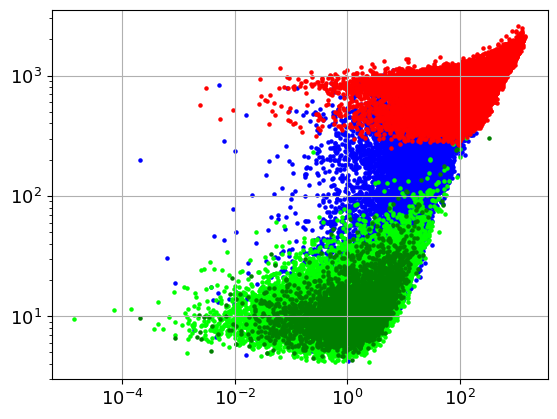

In [71]:
plt.scatter(np.abs(take_norm(ct_grad_mean).ravel() - take_norm(grads_cis_trans).ravel()), take_norm(ct_grad_std).ravel(), c='b', label='Cis-Trans', s=5)
plt.scatter(np.abs(take_norm(train_grad_mean).ravel() - take_norm(grads_trans_train).ravel()), take_norm(train_grad_std).ravel(), c='lime', label='Train', s=5)
plt.scatter(np.abs(take_norm(test_grad_mean).ravel() - take_norm(grads_trans_test).ravel()), take_norm(test_grad_std).ravel(), c='g', label='Test', s=5)
plt.scatter(np.abs(take_norm(cis_grad_mean).ravel() - take_norm(grads_cis).ravel()), take_norm(cis_grad_std).ravel(), c='r', label='Cis', s=5)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

In [72]:
# Plot settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# mpl.rcParams['figure.figsize'] = [7.8,5.9]
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 13

# plt.style.use('seaborn-white')
# sns.set(color_codes=True)

legend_settings = {'loc':'upper center', 'ncol':3, 'frameon':True, 'facecolor':'white',
                   'framealpha':0.8, 'bbox_to_anchor':(0.5, 1.11)}

(120000, 1)


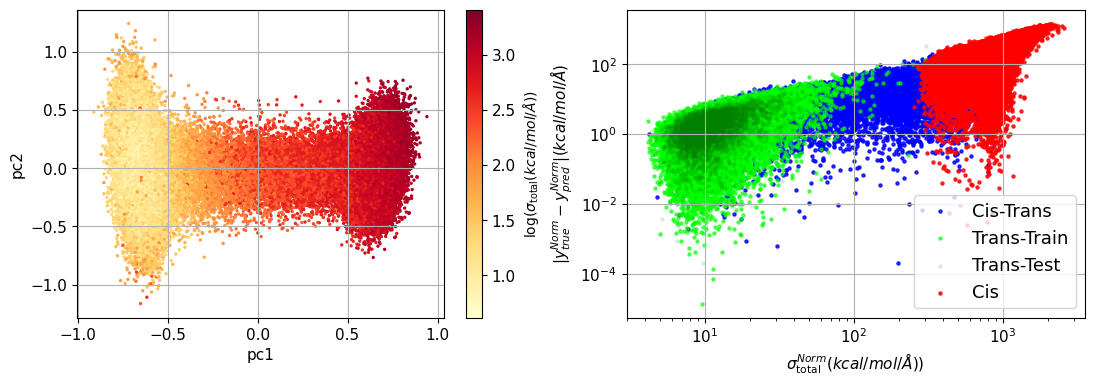

In [73]:
full_std_dev = np.append(np.append(np.append(take_norm(train_grad_std), take_norm(test_grad_std), axis=0), take_norm(ct_grad_std), axis=0), take_norm(cis_grad_std), axis=0)
print(full_std_dev.shape)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

im1 = axes[0].scatter(-X_transformed[:, 0], X_transformed[:, 1], c=np.log10(full_std_dev), s=2, cmap='YlOrRd')

axes[0].set_xlabel('pc1')
axes[0].set_ylabel('pc2')
axes[0].grid()
sbar1 = fig.colorbar(im1, ax=axes[0])
sbar1.set_label(r'log($\sigma_{\mathrm{total}}(kcal/mol/{\AA}))$', fontsize=10)
#plt.savefig('PCA_std_dev.png', dpi=600)

axes[1].scatter(y=np.abs(take_norm(ct_grad_mean).ravel() - take_norm(grads_cis_trans).ravel()), x=take_norm(ct_grad_std).ravel(), c='b', label='Cis-Trans', alpha=0.8, s=5)
axes[1].scatter(y=np.abs(take_norm(train_grad_mean).ravel() - take_norm(grads_trans_train).ravel()), x=take_norm(train_grad_std).ravel(), c='lime', label='Trans-Train', alpha=0.6, s=5)
axes[1].scatter(y=np.abs(take_norm(test_grad_mean).ravel() - take_norm(grads_trans_test).ravel()), x=take_norm(test_grad_std).ravel(), c='g', label='Trans-Test', alpha=0.1, s=5)
axes[1].scatter(y=np.abs(take_norm(cis_grad_mean).ravel() - take_norm(grads_cis).ravel()), x=take_norm(cis_grad_std).ravel(), c='r', label='Cis', alpha=0.8, s=5)

axes[1].set_ylabel(r'$|y_{true}^{Norm} - y_{pred}^{Norm}| (kcal/ mol/{\AA})$')
axes[1].set_xlabel(r'$\sigma_{\mathrm{total}}^{Norm}(kcal/mol/{\AA}))$')
axes[1].grid()
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()
plt.savefig('Acrolein_DE_Force.png', dpi=600, bbox_inches='tight')
plt.show()

(120000, 1)


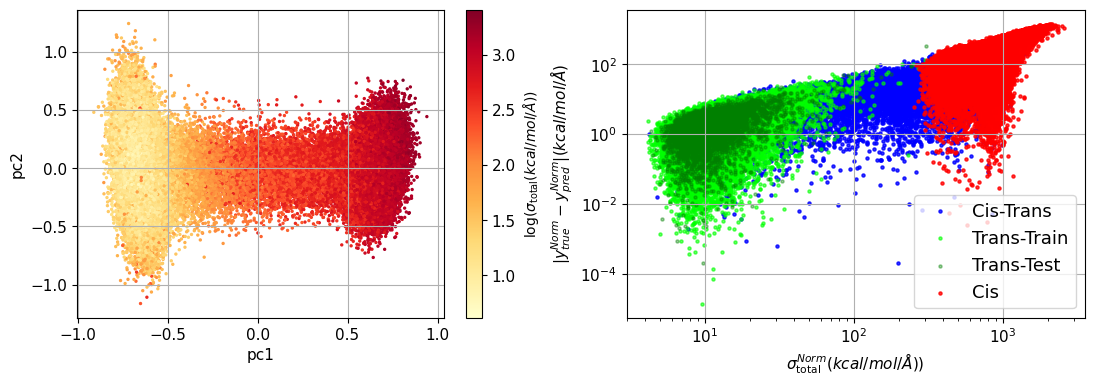

In [74]:
full_std_dev = np.append(
    np.append(
        np.append(take_norm(train_grad_std), take_norm(test_grad_std), axis=0),
        take_norm(ct_grad_std), axis=0
    ),
    take_norm(cis_grad_std), axis=0
)
print(full_std_dev.shape)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Subplot 1
im1 = axes[0].scatter(
    -X_transformed[:, 0], X_transformed[:, 1],
    c=np.log10(full_std_dev), s=2, cmap='YlOrRd'
)

axes[0].set_xlabel('pc1')
axes[0].set_ylabel('pc2')
axes[0].grid()

sbar1 = fig.colorbar(im1, ax=axes[0])
sbar1.set_label(r'log($\sigma_{\mathrm{total}}(kcal/mol/{\AA}))$', fontsize=10)

# Subplot 2 with adjusted alpha
axes[1].scatter(
    y=np.abs(take_norm(ct_grad_mean).ravel() - take_norm(grads_cis_trans).ravel()),
    x=take_norm(ct_grad_std).ravel(), c='b', label='Cis-Trans', alpha=0.8, s=5
)
axes[1].scatter(
    y=np.abs(take_norm(train_grad_mean).ravel() - take_norm(grads_trans_train).ravel()),
    x=take_norm(train_grad_std).ravel(), c='lime', label='Trans-Train', alpha=0.6, s=5
)
axes[1].scatter(
    y=np.abs(take_norm(test_grad_mean).ravel() - take_norm(grads_trans_test).ravel()),
    x=take_norm(test_grad_std).ravel(), c='g', label='Trans-Test', alpha=0.4, s=5
)
axes[1].scatter(
    y=np.abs(take_norm(cis_grad_mean).ravel() - take_norm(grads_cis).ravel()),
    x=take_norm(cis_grad_std).ravel(), c='r', label='Cis', alpha=0.8, s=5
)

axes[1].set_ylabel(r'$|y_{true}^{Norm} - y_{pred}^{Norm}| (kcal/ mol/{\AA})$')
axes[1].set_xlabel(r'$\sigma_{\mathrm{total}}^{Norm}(kcal/mol/{\AA}))$')
axes[1].grid()
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

plt.savefig('Acrolein_DE_Force.png', dpi=600, bbox_inches='tight')
plt.show()


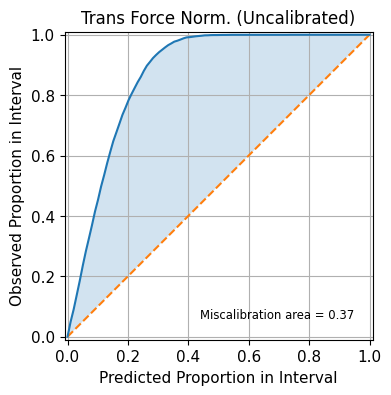

In [75]:
uct.viz.plot_calibration(take_norm(test_grad_mean).ravel(), take_norm(test_grad_std).ravel(), take_norm(grads_trans_test).ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Trans Force Norm. (Uncalibrated)')
plt.grid()
# plt.show()
plt.savefig('Calibration_Force_Test.png', dpi=600, bbox_inches='tight')

In [76]:
unct_metrics_bc_gpnormal = uct.metrics.get_all_metrics(take_norm(test_grad_mean).ravel(), take_norm(test_grad_std).ravel(), take_norm(grads_trans_test).ravel())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.295
  RMSE          6.666
  MDAE          1.507
  MARPD         0.298
  R2            0.999
  Correlation   1.000
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.418
  Mean-absolute Calibration Error       0.366
  Miscalibration Area                   0.370
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.372
     Group Size: 0.56 -- Calibration Error: 0.368
     Group Size: 1.00 -- Calibration Error: 0.366
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.424
     Group Size: 0.56 -- Calibration Error: 0.420
     Group Size: 1.00 -- Calibration Error: 0.418
================

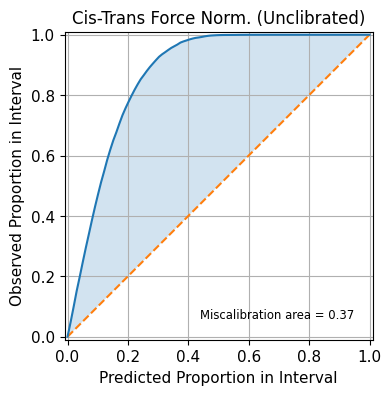

In [77]:
uct.viz.plot_calibration(take_norm(ct_grad_mean).ravel(), take_norm(ct_grad_std).ravel(), take_norm(grads_cis_trans).ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Cis-Trans Force Norm. (Unclibrated)')
plt.grid()
# plt.show()
plt.savefig('Calibration_Force_Cis-Trans.png', dpi=600, bbox_inches='tight')

In [78]:
unct_metrics_bc_gpnormal = uct.metrics.get_all_metrics(take_norm(ct_grad_mean).ravel(), take_norm(ct_grad_std).ravel(), take_norm(grads_cis_trans).ravel())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           61.784
  RMSE          132.683
  MDAE          16.309
  MARPD         10.134
  R2            0.595
  Correlation   0.849
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.415
  Mean-absolute Calibration Error       0.365
  Miscalibration Area                   0.369
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.368
     Group Size: 0.56 -- Calibration Error: 0.366
     Group Size: 1.00 -- Calibration Error: 0.365
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.418
     Group Size: 0.56 -- Calibration Error: 0.416
     Group Size: 1.00 -- Calibration Error: 0.415
===========

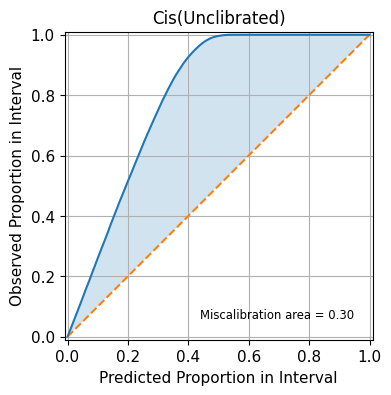

In [79]:
uct.viz.plot_calibration(take_norm(cis_grad_mean).ravel(), take_norm(cis_grad_std).ravel(), take_norm(grads_cis).ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Cis(Unclibrated)')
plt.grid()
plt.show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4139 4138 4137 4136 4135 4134 4133 4132 4131 4130 4129 4128 4127 4126
 4125 4124 4123 4122 4121 4120]


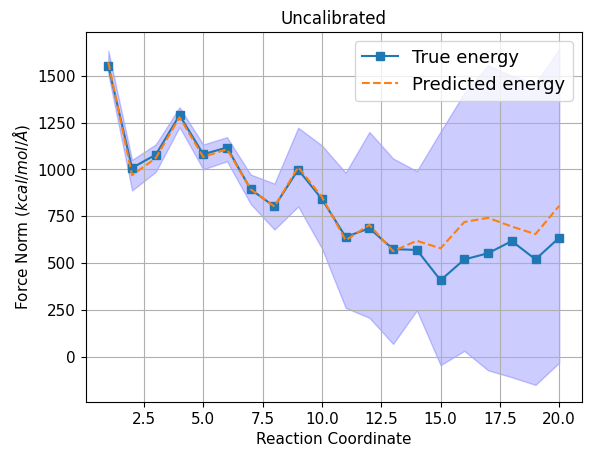

In [80]:
x = np.linspace(1, 20, 20).astype(int)
print(x)
act_indices = indices - 50000
act_indices = act_indices[::-1]
print(act_indices)
plt.plot(x, take_norm(grads_cis_trans[act_indices]), 's-', label='True energy')
plt.plot(x, take_norm(ct_grad_mean[act_indices]), '--', label='Predicted energy')
plt.fill_between(x, take_norm(ct_grad_mean[act_indices]).flatten() - take_norm(ct_grad_std[act_indices]).flatten(), take_norm(ct_grad_mean[act_indices]).flatten() +  take_norm(ct_grad_std[act_indices]).flatten(), alpha=0.2, color='b')
plt.ylabel('Force Norm '+ r'$(kcal/mol/{\AA})$')
plt.xlabel('Reaction Coordinate')
plt.title('Uncalibrated')
plt.grid()
plt.legend()
plt.show()

In [81]:
np.abs(take_norm(grads_cis_trans[act_indices]) - take_norm(ct_grad_mean[act_indices])).flatten()

array([ 19.93787586,  38.80622571,  18.27566162,  10.4202859 ,
        14.50181865,   9.10702861,   0.81096424,   0.59222926,
        13.59411182,  11.63601702,  17.99278637,  18.31594248,
        10.8077798 ,  48.89543744, 170.25177606, 199.79647026,
       189.32490125,  77.65040883, 134.73529613, 170.28752458])

In [82]:
take_norm(ct_grad_std[act_indices]).flatten()

array([ 62.26085789,  81.83122077,  73.37151557,  53.14724669,
        66.35843322,  64.49121223,  78.65167681, 122.88855538,
       210.46684236, 275.08956161, 360.92732566, 496.23666405,
       495.12259289, 372.12987382, 623.74115763, 688.33356091,
       814.37464116, 804.73289371, 805.19838217, 837.78873909])

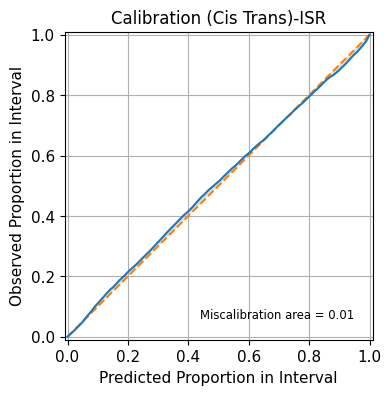

In [83]:
recal_pred_mean = take_norm(test_grad_mean).flatten()
recal_y = take_norm(grads_trans_test).flatten()
recal_pred_std = take_norm(test_grad_std).flatten()
exp_props, obs_props = uct.metrics_calibration.get_proportion_lists_vectorized(
    recal_pred_mean, recal_pred_std, recal_y,
)
# Train a recalibration model.
recal_model = uct.recalibration.iso_recal(exp_props, obs_props)

te_recal_exp_props, te_recal_obs_props = uct.metrics_calibration.get_proportion_lists_vectorized(
    take_norm(ct_grad_mean).flatten(), take_norm(ct_grad_std).flatten(), take_norm(grads_cis_trans).flatten(), recal_model=recal_model
)

uct.viz.plot_calibration(take_norm(ct_grad_mean).flatten(), take_norm(ct_grad_std).flatten(), take_norm(grads_cis_trans).flatten(),
                         exp_props=te_recal_exp_props,
                         obs_props=te_recal_obs_props)
plt.gcf().set_size_inches(4, 4)
plt.title('Calibration (Cis Trans)-ISR')
plt.grid()
plt.savefig('Calibration_Force_Cis-Trans_ISR.png', dpi=600, bbox_inches='tight')

In [84]:
recal_bounds_force = uct.metrics_calibration.get_prediction_interval(
    take_norm(ct_grad_mean).flatten(), take_norm(ct_grad_std).flatten(), 0.6825, recal_model)

In [85]:
isr_std_67_force = (recal_bounds_force.upper - recal_bounds_force.lower) / 2.0
# isr_std_67_force = isr_std_67_force + 20
print(isr_std_67_force)

[169.5863945  157.29366127 149.45178016 ...   4.93968352   2.68082368
   2.15633088]


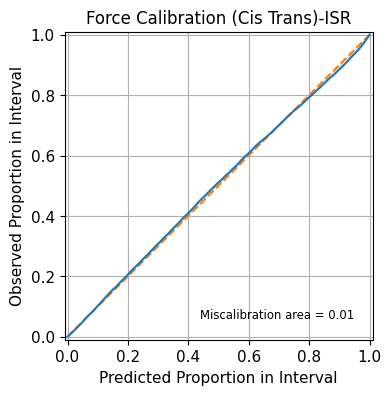

In [86]:
uct.viz.plot_calibration(take_norm(ct_grad_mean).flatten(), isr_std_67_force.flatten(), take_norm(grads_cis_trans).flatten())
plt.gcf().set_size_inches(4, 4)
plt.title('Force Calibration (Cis Trans)-ISR')
plt.grid()
# plt.show()
plt.savefig('Calibration_Force_Cis-Trans_ISR_Modified.png', dpi=600, bbox_inches='tight')

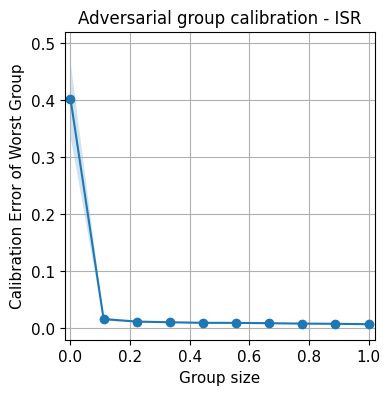

In [87]:
uct.viz.plot_adversarial_group_calibration(take_norm(ct_grad_mean).flatten(), isr_std_67_force.flatten(), take_norm(grads_cis_trans).flatten())
plt.gcf().set_size_inches(4, 4)
plt.title('Adversarial group calibration - ISR')
plt.grid()
# plt.show()
plt.savefig('AGC-ISR_ws22_Force_ISR.png', dpi=600, bbox_inches='tight')

In [88]:
uct.get_all_adversarial_group_calibration(take_norm(ct_grad_mean).flatten(), isr_std_67_force.flatten(), take_norm(grads_cis_trans).flatten(), num_bins=100, verbose=True)

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


{'ma_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
         0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
  'adv_group_cali_mean': array([0.38771717, 0.01315772, 0.01199117, 0.0109031 , 0.01014574,
         0.00923277, 0.00922926, 0.00827667, 0.00792838, 0.00721256]),
  'adv_group_cali_stderr': array([6.33423758e-02, 2.20616195e-03, 1.44245054e-03, 1.36810758e-03,
         6.71160600e-04, 7.43355732e-04, 5.15223153e-04, 2.73652881e-04,
         3.17682097e-04, 9.14279549e-19])},
 'rms_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
         0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
  'adv_group_cali_mean': array([0.45936595, 0.01761087, 0.01382579, 0.01185915, 0.01110908,
         0.01079623, 0.0104843 , 0.00984467, 0.00916063, 0.00837504]),
  'adv_group_cali_stderr': array([0.06204308, 0.00416892, 0.0026403 , 0.00139077, 0.00076645,
         0.001

In [89]:
unct_metrics_bc_gpnormal = uct.metrics.get_all_metrics(take_norm(ct_grad_mean).flatten(), isr_std_67_force.flatten(), take_norm(grads_cis_trans).flatten())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           61.784
  RMSE          132.683
  MDAE          16.309
  MARPD         10.134
  R2            0.595
  Correlation   0.849
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.008
  Mean-absolute Calibration Error       0.007
  Miscalibration Area                   0.007
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.013
     Group Size: 0.56 -- Calibration Error: 0.010
     Group Size: 1.00 -- Calibration Error: 0.007
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.016
     Group Size: 0.56 -- Calibration Error: 0.011
     Group Size: 1.00 -- Calibration Error: 0.008
===========

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4139 4138 4137 4136 4135 4134 4133 4132 4131 4130 4129 4128 4127 4126
 4125 4124 4123 4122 4121 4120]


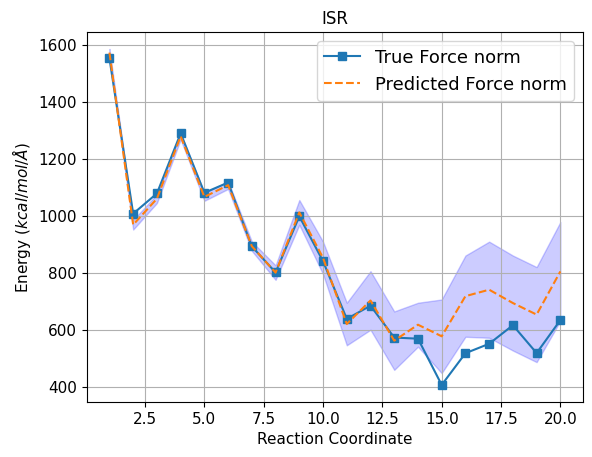

In [90]:
x = np.linspace(1, 20, 20).astype(int)
print(x)
act_indices = indices - 50000
act_indices = act_indices[::-1]
print(act_indices)
plt.plot(x, take_norm(grads_cis_trans[act_indices]), 's-', label='True Force norm')
plt.plot(x, take_norm(ct_grad_mean[act_indices]), '--', label='Predicted Force norm')
plt.fill_between(x, recal_bounds_force.lower[act_indices], recal_bounds_force.upper[act_indices], alpha=0.2, color='b')
plt.ylabel('Energy '+ r'$(kcal/mol/{\AA})$')
plt.xlabel('Reaction Coordinate')
plt.title('ISR')
plt.grid()
plt.legend()
plt.show()

In [91]:
(recal_bounds_force.upper[act_indices] - recal_bounds_force.lower[act_indices]) / 2

array([ 12.8681247 ,  16.91294321,  15.16448446,  10.98451613,
        13.7150149 ,  13.32909615,  16.25579248,  25.39870649,
        43.49945801,  56.85573414,  74.59675297, 102.56259699,
       102.33233985,  76.91210473, 128.91532933, 142.26533973,
       168.31561262, 166.32284843, 166.41905596, 173.15485741])

std scaling -> 0.20844742744259356


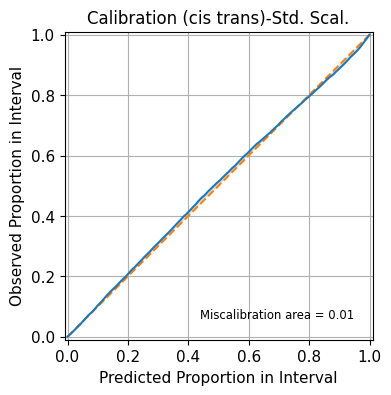

In [92]:
std_scaling = uct.recalibration.optimize_recalibration_ratio(
      recal_pred_mean, recal_pred_std, recal_y, criterion="miscal")
new_pred_stds = std_scaling * take_norm(ct_grad_std).flatten()
print('std scaling ->', std_scaling)
 # Show the updated average calibration plot
uct.viz.plot_calibration(take_norm(ct_grad_mean).flatten(), new_pred_stds, take_norm(grads_cis_trans).ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Calibration (cis trans)-Std. Scal.')
plt.grid()
plt.savefig('Calibration_Force_Cis-Trans_Std_Scaling.png', dpi=600, bbox_inches='tight')

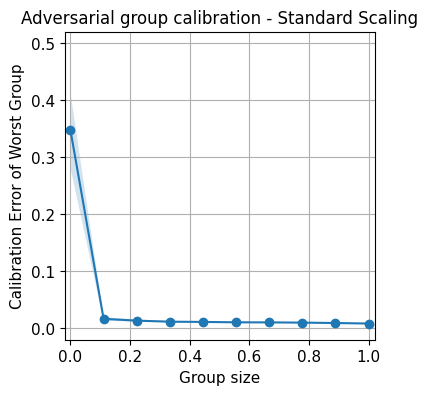

In [93]:
uct.viz.plot_adversarial_group_calibration(take_norm(ct_grad_mean).flatten(), new_pred_stds, take_norm(grads_cis_trans).flatten())
plt.gcf().set_size_inches(4, 4)
plt.title('Adversarial group calibration - Standard Scaling')
plt.grid()
# plt.show()
plt.savefig('AGC-ws22_Force_SS.png', dpi=600, bbox_inches='tight')

In [94]:
unct_metrics_bc_gpnormal = uct.metrics.get_all_metrics(take_norm(ct_grad_mean).flatten(), new_pred_stds, take_norm(grads_cis_trans).ravel())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           61.784
  RMSE          132.683
  MDAE          16.309
  MARPD         10.134
  R2            0.595
  Correlation   0.849
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.010
  Mean-absolute Calibration Error       0.008
  Miscalibration Area                   0.008
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.017
     Group Size: 0.56 -- Calibration Error: 0.011
     Group Size: 1.00 -- Calibration Error: 0.008
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.019
     Group Size: 0.56 -- Calibration Error: 0.012
     Group Size: 1.00 -- Calibration Error: 0.010
===========

In [95]:
mod_new_pred_stds_force = new_pred_stds
# mod_new_pred_stds_force

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4139 4138 4137 4136 4135 4134 4133 4132 4131 4130 4129 4128 4127 4126
 4125 4124 4123 4122 4121 4120]


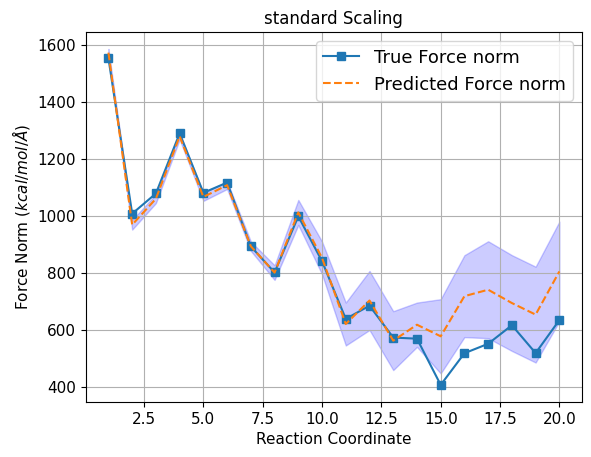

In [96]:
x = np.linspace(1, 20, 20).astype(int)
print(x)
act_indices = indices - 50000
act_indices = act_indices[::-1]
print(act_indices)
plt.plot(x, take_norm(grads_cis_trans[act_indices]), 's-', label='True Force norm')
plt.plot(x, take_norm(ct_grad_mean[act_indices]), '--', label='Predicted Force norm')
plt.fill_between(x, take_norm(ct_grad_mean[act_indices]).flatten() - std_scaling * take_norm(ct_grad_std[act_indices]).flatten(), take_norm(ct_grad_mean[act_indices]).flatten() + std_scaling * take_norm(ct_grad_std[act_indices]).flatten(), alpha=0.2, color='b')
plt.ylabel('Force Norm '+ r'$(kcal/mol/{\AA})$')
plt.xlabel('Reaction Coordinate')
plt.title('standard Scaling')
plt.grid()
plt.legend()
plt.show()

In [97]:
std_scaling * take_norm(ct_grad_std[act_indices]).flatten()

array([ 12.97811566,  17.05750745,  15.29410367,  11.07840685,
        13.83224469,  13.44302728,  16.3947397 ,  25.61580323,
        43.87127185,  57.34171143,  75.23437253, 103.43925602,
       103.20703076,  77.56951487, 130.0172397 , 143.48135999,
       169.75429892, 167.74450147, 167.84153134, 174.6349074 ])

Loss: 2.2681: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


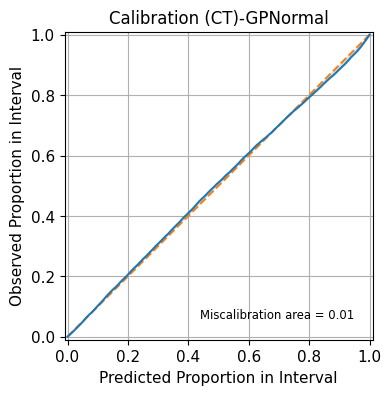

In [98]:
gpnormal = GPNormal(n_inducing_points=50, n_random_samples=256, n_epochs=50, use_cuda=use_cuda)
gpnormal.fit((take_norm(test_grad_mean).reshape(-1, 1), take_norm(test_grad_std).reshape(-1, 1)),take_norm(grads_trans_test).reshape(-1, 1), tensorboard=tensorboard)
ystd_gpnormal = gpnormal.transform((take_norm(ct_grad_mean).reshape(-1, 1), take_norm(ct_grad_std).reshape(-1, 1)))

uct.viz.plot_calibration(take_norm(ct_grad_mean).ravel(), ystd_gpnormal.ravel(),take_norm(grads_cis_trans).ravel())
plt.gcf().set_size_inches(4, 4)
plt.title('Calibration (CT)-GPNormal')
plt.grid()
# plt.show()
plt.savefig('Calibration_Force_Cis-Trans_GPNormal.png', dpi=600, bbox_inches='tight')

In [99]:
mod_ystd_gpnormal_force = ystd_gpnormal.ravel()

In [100]:
unct_metrics_bc_gpnormal = uct.metrics.get_all_metrics(take_norm(ct_grad_mean).ravel(), ystd_gpnormal.ravel(),take_norm(grads_cis_trans).ravel())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           61.784
  RMSE          132.683
  MDAE          16.309
  MARPD         10.134
  R2            0.595
  Correlation   0.849
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.008
  Mean-absolute Calibration Error       0.007
  Miscalibration Area                   0.007
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.014
     Group Size: 0.56 -- Calibration Error: 0.010
     Group Size: 1.00 -- Calibration Error: 0.007
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.018
     Group Size: 0.56 -- Calibration Error: 0.010
     Group Size: 1.00 -- Calibration Error: 0.008
===========

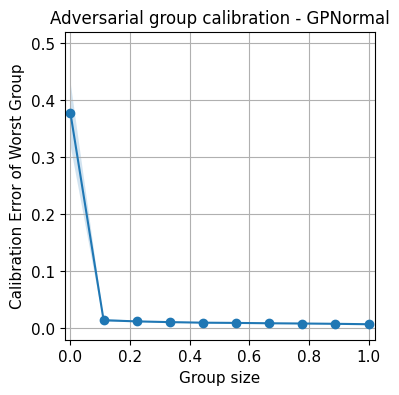

In [101]:
uct.viz.plot_adversarial_group_calibration(take_norm(ct_grad_mean).flatten(), ystd_gpnormal.ravel(), take_norm(grads_cis_trans).flatten())
plt.gcf().set_size_inches(4, 4)
plt.title('Adversarial group calibration - GPNormal')
plt.grid()
# plt.show()
plt.savefig('AGC-ws22_Force_GPNormal.png', dpi=600, bbox_inches='tight')

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4139 4138 4137 4136 4135 4134 4133 4132 4131 4130 4129 4128 4127 4126
 4125 4124 4123 4122 4121 4120]


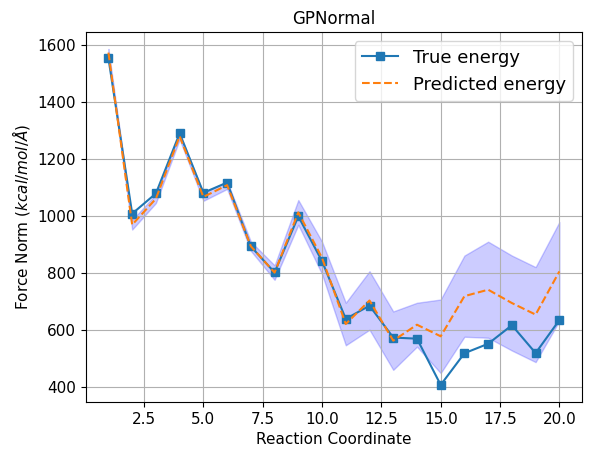

In [102]:
x = np.linspace(1, 20, 20).astype(int)
print(x)
act_indices = indices - 50000
act_indices = act_indices[::-1]
print(act_indices)
plt.plot(x, take_norm(grads_cis_trans[act_indices]), 's-', label='True energy')
plt.plot(x, take_norm(ct_grad_mean[act_indices]), '--', label='Predicted energy')
plt.fill_between(x, take_norm(ct_grad_mean[act_indices]).flatten() - ystd_gpnormal[act_indices].flatten(), take_norm(ct_grad_mean[act_indices]).flatten() + ystd_gpnormal[act_indices].flatten(), alpha=0.2, color='b')
plt.ylabel('Force Norm '+ r'$(kcal/mol/{\AA})$')
plt.xlabel('Reaction Coordinate')
plt.title('GPNormal')
plt.grid()
plt.legend()
plt.show()

In [103]:
ystd_gpnormal[act_indices].flatten()

array([ 12.862512 ,  16.905077 ,  15.15767  ,  10.9799185,  13.708985 ,
        13.322908 ,  16.247828 ,  25.385176 ,  43.476067 ,  56.82313  ,
        74.551994 , 102.501724 , 102.271164 ,  76.86598  , 128.8386   ,
       142.18109  , 168.21606  , 166.22438  , 166.32043  , 173.05261  ],
      dtype=float32)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4139 4138 4137 4136 4135 4134 4133 4132 4131 4130 4129 4128 4127 4126
 4125 4124 4123 4122 4121 4120]


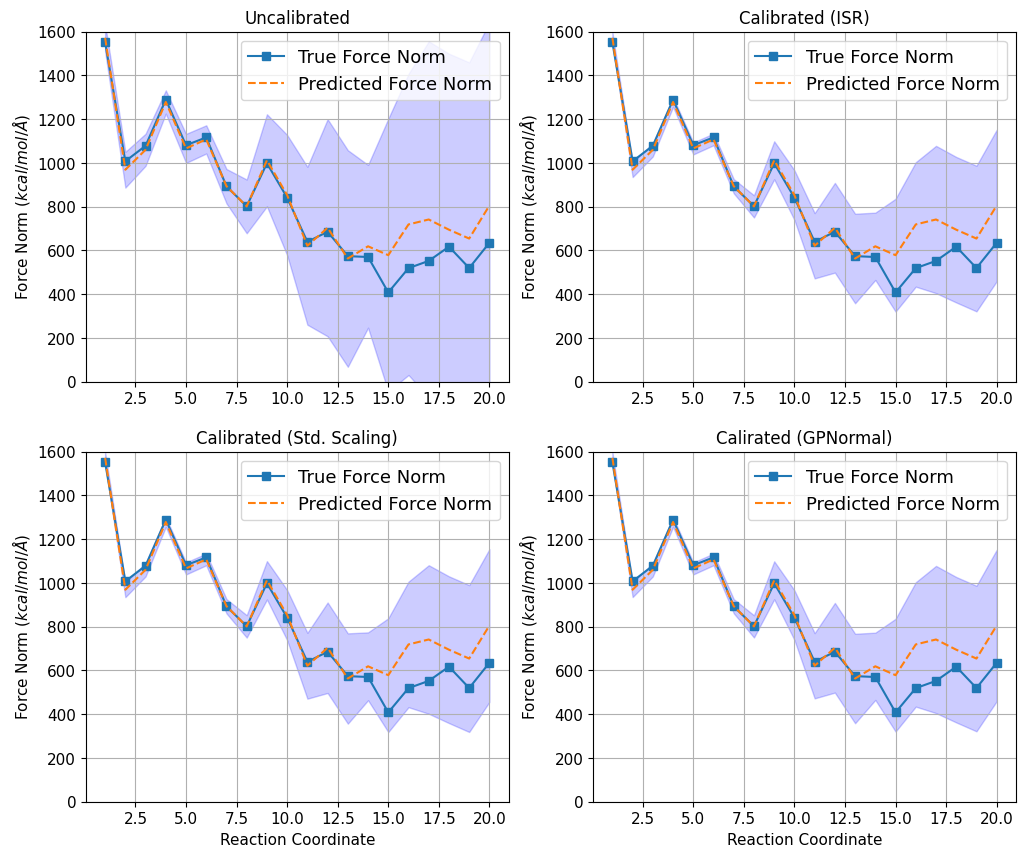

In [104]:
x = np.linspace(1, 20, 20).astype(int)
print(x)
act_indices = indices - 50000
act_indices = act_indices[::-1]
print(act_indices)
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(x, take_norm(grads_cis_trans[act_indices]), 's-', label='True Force Norm')
plt.plot(x, take_norm(ct_grad_mean[act_indices]), '--', label='Predicted Force Norm')
plt.fill_between(x, take_norm(ct_grad_mean[act_indices]).flatten() - take_norm(ct_grad_std[act_indices]).flatten(), take_norm(ct_grad_mean[act_indices]).flatten() +  take_norm(ct_grad_std[act_indices]).flatten(), alpha=0.2, color='b')
plt.ylabel('Force Norm '+ r'$(kcal/mol/{\AA})$')
plt.ylim(0, 1600)
# plt.xlabel('Reaction Coordinate')
plt.title('Uncalibrated')
plt.grid()
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(x, take_norm(grads_cis_trans[act_indices]), 's-', label='True Force Norm')
plt.plot(x, take_norm(ct_grad_mean[act_indices]), '--', label='Predicted Force Norm')
plt.fill_between(x, take_norm(ct_grad_mean[act_indices]).flatten() - 2 * isr_std_67_force[act_indices].ravel(), take_norm(ct_grad_mean[act_indices]).flatten() + 2 * isr_std_67_force[act_indices].ravel(), alpha=0.2, color='b')
plt.ylabel('Force Norm '+ r'$(kcal/mol/{\AA})$')
# plt.xlabel('Reaction Coordinate')
plt.title('Calibrated (ISR)')
plt.ylim(0, 1600)
plt.grid()
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(x, take_norm(grads_cis_trans[act_indices]), 's-', label='True Force Norm')
plt.plot(x, take_norm(ct_grad_mean[act_indices]), '--', label='Predicted Force Norm')
plt.fill_between(x, take_norm(ct_grad_mean[act_indices]).flatten() - 2 * mod_new_pred_stds_force[act_indices].flatten(), take_norm(ct_grad_mean[act_indices]).flatten() + 2 * mod_new_pred_stds_force[act_indices].flatten(), alpha=0.2, color='b')
plt.ylabel('Force Norm '+ r'$(kcal/mol/{\AA})$')
plt.xlabel('Reaction Coordinate')
plt.title('Calibrated (Std. Scaling)')
plt.ylim(0, 1600)
plt.grid()
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(x, take_norm(grads_cis_trans[act_indices]), 's-', label='True Force Norm')
plt.plot(x, take_norm(ct_grad_mean[act_indices]), '--', label='Predicted Force Norm')
plt.fill_between(x, take_norm(ct_grad_mean[act_indices]).flatten() - 2 * mod_ystd_gpnormal_force[act_indices].flatten(), take_norm(ct_grad_mean[act_indices]).flatten() + 2 * mod_ystd_gpnormal_force[act_indices].flatten(), alpha=0.2, color='b')
plt.ylabel('Force Norm '+ r'$(kcal/mol/{\AA})$')
plt.xlabel('Reaction Coordinate')
plt.title('Calirated (GPNormal)')
plt.ylim(0, 1600)
plt.grid()
plt.legend()
plt.savefig('Calibration_Comparison_Force_mod.png', dpi=600, bbox_inches='tight')
# plt.show()

In [107]:
threshold = 10
tolerance = 0

indices_1_force = np.where(2 * take_norm(ct_grad_std)[indices_1_energy] < threshold)[0]
# indices_2 = np.where(take_norm(ct_grad_std) < 2 * mean_with_outliers)[0]
# indices_3 = np.where(take_norm(ct_grad_std) < 3 * mean_with_outliers)[0]
# print(indices)
pca_indices_1_force = 50000 + indices_1_force
# pca_indices_2 = 50000 + indices_2
# pca_indices_3 = 50000 + indices_3

print('Samples with low uncertainty:', np.shape(indices_1_force))

false_indices_force = np.where(np.abs(take_norm(ct_grad_mean[indices_1_energy][indices_1_force]) - take_norm(grads_cis_trans[indices_1_energy][indices_1_force])) > threshold)
print('Points with high error:', false_indices_force[0].shape)

isr_std_67_force = (recal_bounds_force.upper - recal_bounds_force.lower) / 2.0
indices_1_isr_force = np.where(2 * isr_std_67_force[indices_1_isr_energy] + tolerance < threshold)[0]
pca_indices_1_isr_force = 50000 + indices_1_isr_force
print('Samples with low uncertainty:', np.shape(indices_1_isr_force))

false_indices_isr_force = np.where(np.abs(take_norm(ct_grad_mean[indices_1_isr_energy][indices_1_isr_force]).ravel() - take_norm(grads_cis_trans[indices_1_isr_energy][indices_1_isr_force]).ravel()) > threshold)
print('Points with high error:', false_indices_isr_force[0].shape)

indices_1_ss_force = np.where(2 * take_norm(ct_grad_std)[indices_1_ss_energy] * std_scaling + tolerance < threshold)[0]
pca_indices_1_ss_force = 50000 + indices_1_ss_force
print('Samples with low uncertainty:', np.shape(indices_1_ss_force))

false_indices_ss_force = np.where(np.abs(take_norm(ct_grad_mean[indices_1_ss_energy][indices_1_ss_force]) - take_norm(grads_cis_trans[indices_1_ss_energy][indices_1_ss_force])) > threshold)
print('Points with high error:', false_indices_ss_force[0].shape)

indices_1_gp_force = np.where(2 * ystd_gpnormal[indices_1_gp_energy] + tolerance < threshold)[0]
pca_indices_1_gp_force = 50000 + indices_1_gp_force
print('Samples with low uncertainty:', np.shape(indices_1_gp_force))

false_indices_gp_force = np.where(np.abs(take_norm(ct_grad_mean[indices_1_gp_energy][indices_1_gp_force]) - take_norm(grads_cis_trans[indices_1_gp_energy][indices_1_gp_force])) > threshold)
print('Points with high error:', false_indices_gp_force[0].shape)

Samples with low uncertainty: (3,)
Points with high error: (0,)
Samples with low uncertainty: (4546,)
Points with high error: (61,)
Samples with low uncertainty: (4518,)
Points with high error: (60,)
Samples with low uncertainty: (4549,)
Points with high error: (61,)


In [108]:
print(indices_1_energy.shape)
print(indices_1_isr_energy.shape)
print(indices_1_ss_energy.shape)
print(indices_1_gp_energy.shape)

(5226,)
(5904,)
(5875,)
(5921,)
